<a href="https://colab.research.google.com/github/AnkurBambhrolia/Vibrio/blob/main/Vibrio_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Redo and use average file (Only redo Isolates)
# Import CSV from Github
df_source = 'https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg.csv'  # Use 'raw' URL
df_source = pd.read_csv(df_source)
df_source


,state_name,Year,Month,Source,Serotype_Species,sst,sss,Number_of_isolates
0,Florida,2021,8,Blood,vulnificus,29.794705,35.098029,1.0
1,Florida,2021,10,Blood,vulnificus/Ctx-,28.212380,35.305989,2.0
2,Florida,2022,4,Other,vulnificus/Ctx-,24.351561,35.944011,1.0
3,Florida,2022,5,Blood,vulnificus/Ctx-,26.684198,36.039145,1.0
4,Florida,2022,5,Other,vulnificus/Ctx-,26.684198,36.039145,1.0
...,...,...,...,...,...,...,...,...
97,Virginia,2023,6,Stool,vulnificus/Ctx-,20.087761,34.034250,1.0
98,Virginia,2023,7,Blood,vulnificus/Ctx-,26.229262,33.700263,2.0
99,Virginia,2023,8,Blood,vulnificus/Ctx-,25.829354,34.119863,1.0
100,Virginia,2023,8,Other,vulnificus/Ctx-,25.829354,34.119863,1.0


In [2]:
#List of states for each region
gulf_states = ['Alabama', 'Florida', 'Georgia', 'Louisiana', 'Mississippi', 'Texas']
east_states = ['Georgia', 'South Carolina', 'North Carolina', 'Virginia', 'Maryland', 'Delaware', 'New Jersey', 'New York', 'Connecticut', 'Rhode Island', 'Massachusetts', 'New Hampshire', 'Maine']

#Add a region column
df_source['region'] = df_source['state_name'].apply(lambda x: 'Gulf' if x in gulf_states else 'East' if x in east_states else 'Other')

#Verify the new column
df_source.head(12)

# Save file
# df_source.to_csv('vv_sst_sss_sources_region_avg.csv', index=False)

# Download file
# from google.colab import files
# files.download('vv_sst_sss_sources_region_avg.csv')

,state_name,Year,Month,Source,Serotype_Species,sst,sss,Number_of_isolates,region
0,Florida,2021,8,Blood,vulnificus,29.794705,35.098029,1.0,Gulf
1,Florida,2021,10,Blood,vulnificus/Ctx-,28.212380,35.305989,2.0,Gulf
2,Florida,2022,4,Other,vulnificus/Ctx-,24.351561,35.944011,1.0,Gulf
3,Florida,2022,5,Blood,vulnificus/Ctx-,26.684198,36.039145,1.0,Gulf
4,Florida,2022,5,Other,vulnificus/Ctx-,26.684198,36.039145,1.0,Gulf
5,Florida,2022,6,Blood,vulnificus/Ctx-,28.735857,35.724191,7.0,Gulf
6,Florida,2022,6,Other,vulnificus/Ctx-,28.735857,35.724191,2.0,Gulf
7,Florida,2022,7,Blood,vulnificus/Ctx-,30.146200,35.183587,4.0,Gulf
8,Florida,2022,8,Other,vulnificus/Ctx-,30.190738,34.503896,1.0,Gulf
9,Florida,2022,9,Blood,vulnificus/Ctx-,29.769260,34.628529,11.0,Gulf


In [3]:
# Redo and use average file (Only redo Isolates)
# Import CSV from Github
df_source = 'https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg.csv'  # Use 'raw' URL
df_source = pd.read_csv(df_source)
df_source.columns

# Convert columns to appropriate data types
df_source['Year'] = pd.to_numeric(df_source['Year'], errors='coerce')
df_source['Month'] = pd.to_numeric(df_source['Month'], errors='coerce')
df_source['sst'] = pd.to_numeric(df_source['sst'], errors='coerce')
df_source['sss'] = pd.to_numeric(df_source['sss'], errors='coerce')
df_source['Number_of_isolates'] = pd.to_numeric(df_source['Number_of_isolates'], errors='coerce')

# Create a datetime column
df_source['Date'] = pd.to_datetime(df_source[['Year', 'Month']].assign(DAY=1), errors='coerce')

# Group by Date and compute averages/sums
time_series = df_source.groupby('Date').agg({
    'sst': 'mean', #average of coordinates
    'sss': 'mean', # average
    'Number_of_isolates': 'sum'
}).reset_index()

time_series.head()

,Date,sst,sss,Number_of_isolates
0,2018-08-01,20.810460,31.679759,1.0
1,2019-05-01,25.509852,33.797745,6.0
2,2019-06-01,28.886188,32.758971,10.0
3,2019-07-01,29.516553,34.282280,3.0
4,2020-05-01,23.338399,36.234785,1.0


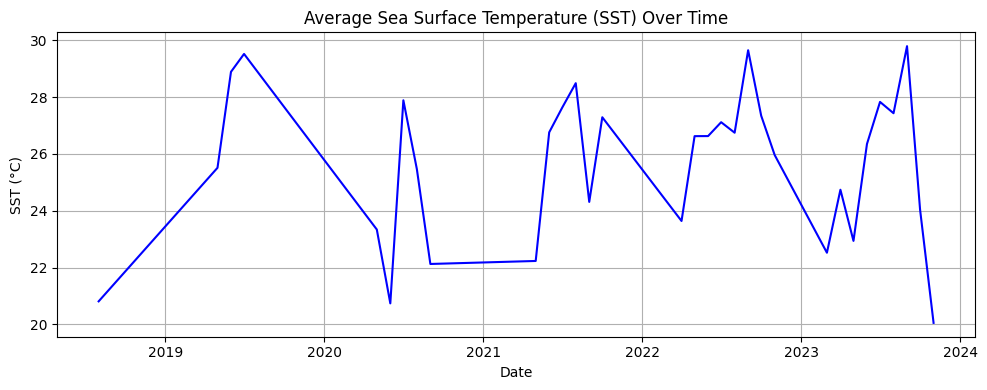

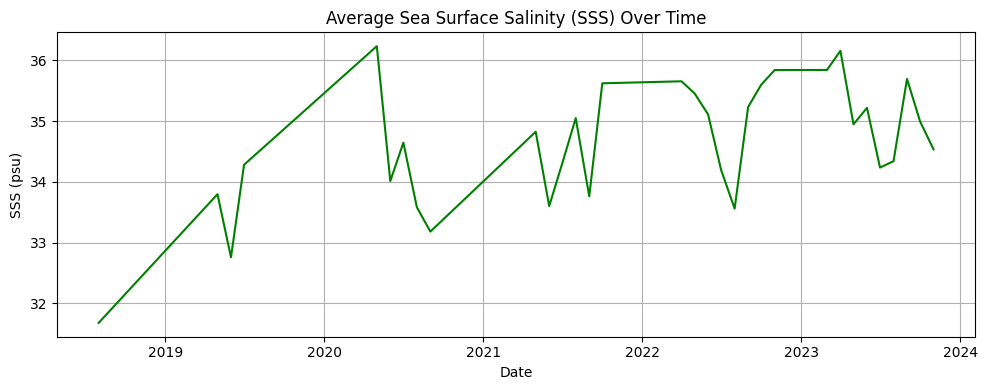

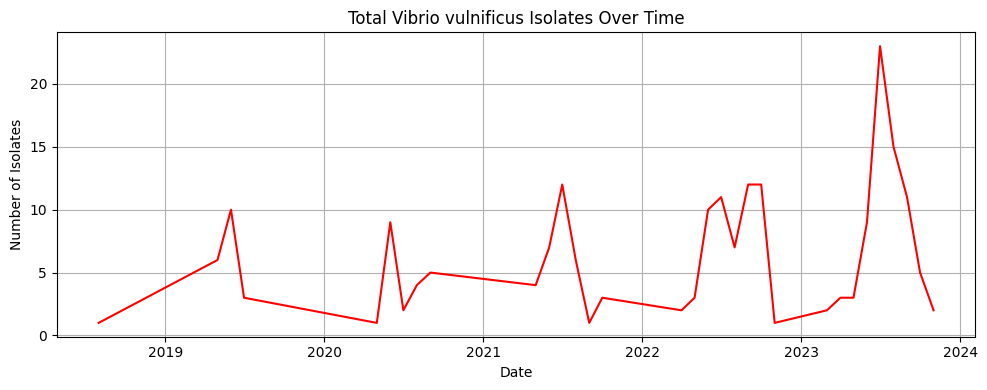

In [4]:
# Create three separate line charts for SST, SSS, and Number of Isolates

# Plot 1: SST over time
plt.figure(figsize=(10, 4))
plt.plot(time_series['Date'], time_series['sst'], color='blue')
plt.title('Average Sea Surface Temperature (SST) Over Time')
plt.xlabel('Date')
plt.ylabel('SST (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: SSS over time
plt.figure(figsize=(10, 4))
plt.plot(time_series['Date'], time_series['sss'], color='green')
plt.title('Average Sea Surface Salinity (SSS) Over Time')
plt.xlabel('Date')
plt.ylabel('SSS (psu)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Number of Isolates over time
plt.figure(figsize=(10, 4))
plt.plot(time_series['Date'], time_series['Number_of_isolates'], color='red')
plt.title('Total Vibrio vulnificus Isolates Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Isolates')
plt.grid(True)
plt.tight_layout()
plt.show()

Determine Stationary or Non-Stationary

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Determine Statonary of of each variable (SSS, SST, Vibrio Count)


# Use the Augmented Dickey-Fuller (ADF) test
# It checks if your series has a unit root, which would imply non-stationarity.


result_cases = adfuller(time_series['Number_of_isolates'].dropna())

#print('ADF Statistic:', result[0])
#print('p-value:', result[1])
#print('Critical Values:')
#for key, value in result[4].items():
    #print(f'   {key}: {value}')



result_sss = adfuller(time_series['sss'].dropna())

#print('\nADF Statistic:', result_sss[0])
#print('p-value:', result_sss[1])
#print('Critical Values:')
#for key, value in result_sss[4].items():
    #print(f'   {key}: {value}')


results_sst = adfuller(time_series['sst'].dropna())

#print('\nADF Statistic:', results_sst[0])
#print('p-value:', results_sst[1])
#print('Critical Values:')
#for key, value in results_sst[4].items():
  #print(f'   {key}: {value}')

pval_df = pd.DataFrame([
                       ['Number_of_isolates', result_cases[0], result_cases[1], '0.05', "Non-Stationary"],
                       ['sss', result_sss[0], result_sss[1], '0.05', "Stationary"],
                       ['sst', results_sst[0], results_sst[1], '0.05', "Stationary"]],
                       columns=['Variable', 'ADF Statistic', 'p-value', 'Critical Values', "Interpertation"])
pval_df

#from google.colab import files
#results_df.to_csv("adf.csv", index=False)
#files.download("adf.csv")


,Variable,ADF Statistic,p-value,Critical Values,Interpertation
0,Number_of_isolates,1.049568,0.994762,0.05,Non-Stationary
1,sss,-4.626811,0.000115,0.05,Stationary
2,sst,-4.035278,0.001237,0.05,Stationary


          ds  forecast
0 2023-12-01     2.531
1 2024-01-01     0.269
2 2024-02-01     0.269
3 2024-03-01     1.497
4 2024-04-01     2.692


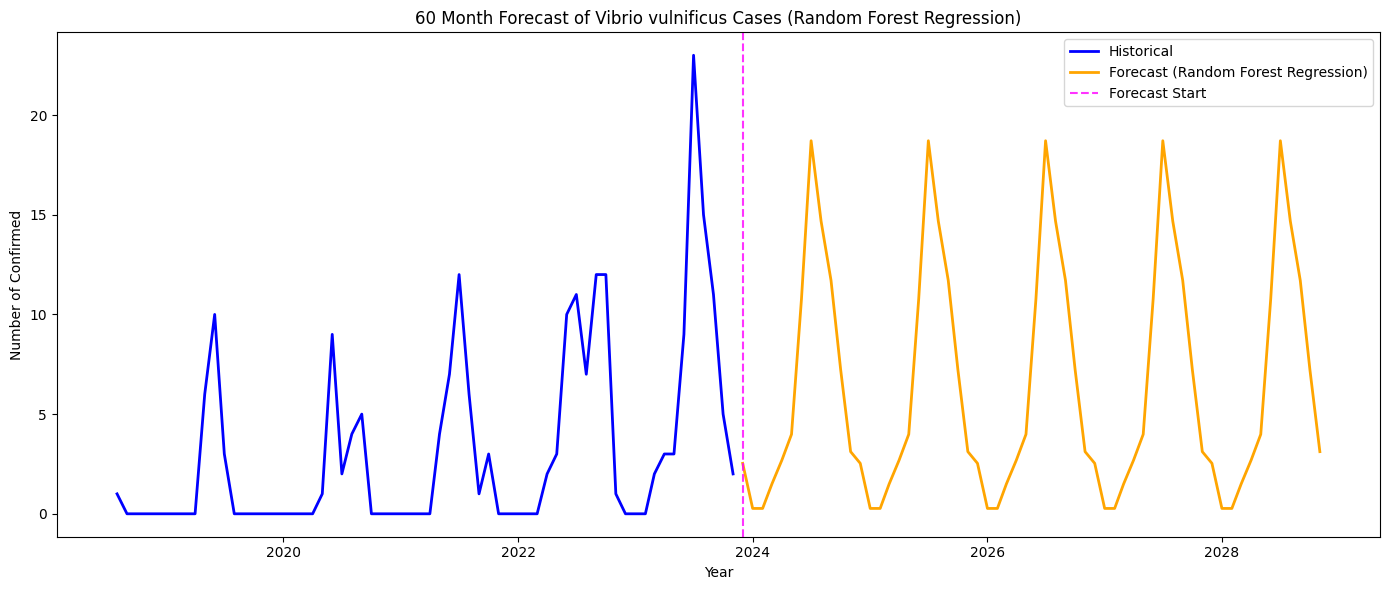

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 1. Load and preprocess data
url = 'https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg.csv'
df = pd.read_csv(url)
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
monthly_df = df.groupby('date')['Number_of_isolates'].sum().reset_index()
vibrio_df = monthly_df.rename(columns={'date': 'ds', 'Number_of_isolates': 'y'})
vibrio_df = vibrio_df[vibrio_df['y'] > 0].copy()
vibrio_df.head()
# 2. Set datetime index and enforce monthly frequency
vibrio_df = vibrio_df.set_index('ds').asfreq('MS')
vibrio_df['y'] = vibrio_df['y'].fillna(0)

# 3. Feature engineering
vibrio_df['year'] = vibrio_df.index.year
vibrio_df['month'] = vibrio_df.index.month

# 4. Train-test split (train on all data, forecast future)
X = vibrio_df[['year', 'month']]
y = vibrio_df['y']

rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X, y)

# 5. Forecast next 60 months
last_date = vibrio_df.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=60, freq='MS')
future_df = pd.DataFrame({
    'ds': future_dates,
    'year': future_dates.year,
    'month': future_dates.month
})

# 6. Make predictions
forecast = rf.predict(future_df[['year', 'month']])
forecast_df = pd.DataFrame({
    'ds': future_df['ds'],
    'forecast': np.clip(forecast, 0, None)  # No negative values
})

# Optional: Add dummy lower/upper CI bounds (not directly available from RF)
# forecast_df['lower'] = forecast_df['forecast'] * 0.8
# forecast_df['upper'] = forecast_df['forecast'] * 1.2

# Preview
print(forecast_df.head())

# Combine historical and forecasted data
vibrio_hist = vibrio_df[['y']].reset_index().rename(columns={'y': 'value'})
vibrio_hist['type'] = 'historical'
forecast_df = forecast_df.rename(columns={'forecast': 'value'})
forecast_df['type'] = 'forecast'


# 8. Plot results
plt.figure(figsize=(14, 6))
plt.plot(vibrio_df.index, vibrio_df['y'], label='Historical', color='blue', lw = 2)
plt.plot(forecast_df['ds'], forecast_df['value'], label='Forecast (Random Forest Regression)', color='orange', lw = 2)
# Vertical line at transition
plt.axvline(x=forecast_df['ds'].min(), color='magenta', linestyle='--', label='Forecast Start', alpha = 0.8)
# plt.fill_between(forecast_df['ds'], forecast_df['lower'], forecast_df['upper'], color='orange', alpha=0.3)
plt.title('60 Month Forecast of Vibrio vulnificus Cases (Random Forest Regression)')
plt.xlabel('Year')
plt.ylabel('Number of Confirmed')
plt.legend()
plt.tight_layout()
# Show Plot
plt.show()


# 9. Combine historical and forecasted data
vibrio_hist = vibrio_df[['y']].reset_index().rename(columns={'y': 'value'})
vibrio_hist['type'] = 'historical'
forecast_df = forecast_df.rename(columns={'forecast': 'value'})
forecast_df['type'] = 'forecast'

# 10. Combine and export
combined_df = pd.concat([vibrio_hist, forecast_df], axis=0, ignore_index=True)
combined_df = combined_df.sort_values(by='ds')
combined_df.to_csv('vibrio_isolates_historical_forecast.csv', index=False)

from google.colab import files
#files.download('vibrio_isolates_historical_forecast.csv')


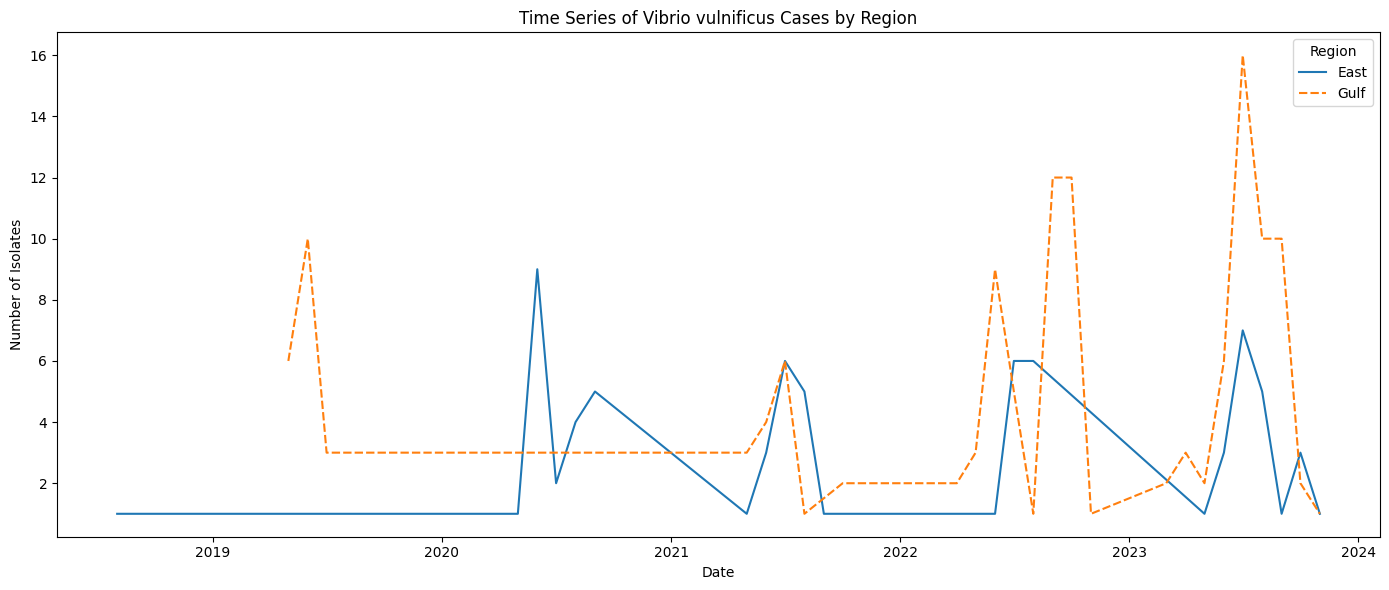

,Region,ADF Statistic,p-value,Critical Value (5%),Stationary at 5%
0,East,-2.858426,0.050400,-3.154972,False
1,Gulf,-3.716491,0.003887,-2.998500,True


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import numpy as np
from IPython.display import display

# Import data
github = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df = pd.read_csv(github)
# Create 'date' column from 'Year' and 'Month'
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

# Aggregate Vibrio cases by month and region
cases_by_region = (
    df.groupby(['date', 'region'])['Number_of_isolates']
    .sum()
    .reset_index()
)

# Pivot for time series plotting
pivot_cases = cases_by_region.pivot(index='date', columns='region', values='Number_of_isolates')

# Plot time series for each region
plt.figure(figsize=(14, 6))
sns.lineplot(data=pivot_cases)
plt.title("Time Series of Vibrio vulnificus Cases by Region")
plt.xlabel("Date")
plt.ylabel("Number of Isolates")
plt.legend(title="Region")
plt.tight_layout()
plt.show()

# Run ADF test for each region
adf_results = []
for region in pivot_cases.columns:
    series = pivot_cases[region].dropna()
    result = adfuller(series)
    adf_results.append({
        'Region': region,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Value (5%)': result[4]['5%'],
        'Stationary at 5%': result[1] < 0.05
    })

# Display results as a DataFrame
adf_df = pd.DataFrame(adf_results)
display(adf_df)

In [8]:
# Cleaning Data

import pandas as pd

# Load the dataset
github = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df = pd.read_csv(github)

# Combine Year and Month into a datetime column
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Filter for relevant columns and regions
df = df[['Date', 'region', 'Number_of_isolates']]
df = df[df['region'].isin(['East', 'Gulf'])]

# Aggregate the data: sum of isolates per region per month
agg_df = df.groupby(['Date', 'region'])['Number_of_isolates'].sum().reset_index()

# Pivot to wide format for comparison
pivot_df = agg_df.pivot(index='Date', columns='region', values='Number_of_isolates')

from IPython.display import display; display(pivot_df.head())



region,East,Gulf
Date,,
2018-08-01,1.0,NaN
2019-05-01,NaN,6.0
2019-06-01,NaN,10.0
2019-07-01,NaN,3.0
2020-05-01,1.0,NaN


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


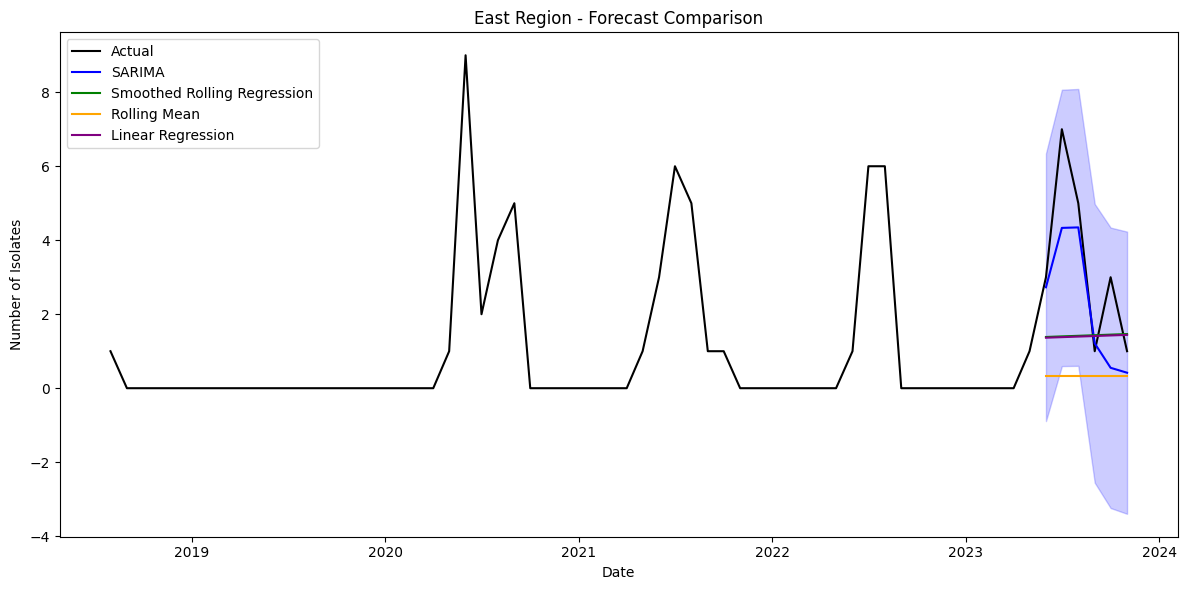

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


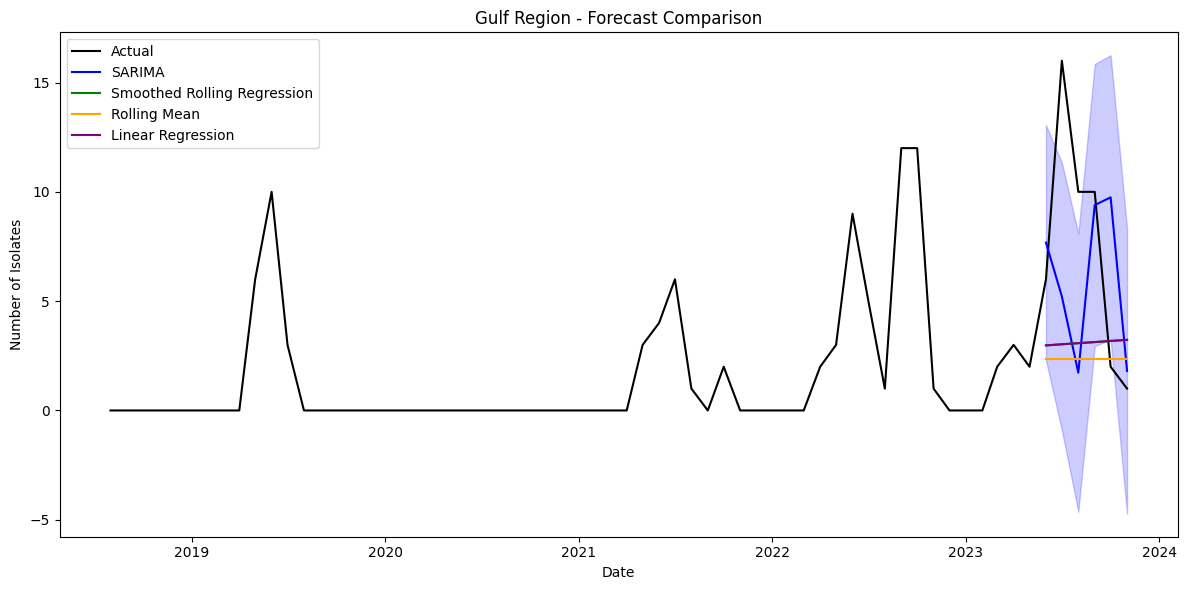

Model Comparison by Region


,Model,Region,MAE,RMSE
0,SARIMA,East,1.139150,1.527131
1,Smoothed Rolling Regression,East,2.207726,2.875584
2,Rolling Mean,East,3.000000,3.681787
3,Linear Regression,East,2.214284,2.889399
4,SARIMA,Gulf,4.981646,6.436148
5,Smoothed Rolling Regression,Gulf,5.535101,6.820999
6,Rolling Mean,Gulf,5.722222,7.299163
7,Linear Regression,Gulf,5.531740,6.816368


In [9]:
# Modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Load and preprocess data
github = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df = pd.read_csv(github)
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df = df[['Date', 'region', 'Number_of_isolates']]
df = df[df['region'].isin(['East', 'Gulf'])]

# Aggregate
agg_df = df.groupby(['Date', 'region'])['Number_of_isolates'].sum().reset_index()
pivot_df = agg_df.pivot(index='Date', columns='region', values='Number_of_isolates')
pivot_df_filled = pivot_df.asfreq('MS').fillna(0)

# Define model evaluation and visualization function
def run_models_updated(region_name, series):
    results = []
    series = series.asfreq('MS')
    train = series[:-6]
    test = series[-6:]

    # SARIMA
    sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
    sarima_forecast = sarima_model.get_forecast(steps=6)
    sarima_mean = sarima_forecast.predicted_mean
    sarima_ci = sarima_forecast.conf_int()

    mae_s = mean_absolute_error(test, sarima_mean)
    rmse_s = sqrt(mean_squared_error(test, sarima_mean))
    results.append(['SARIMA', region_name, mae_s, rmse_s])

    # Smoothed Rolling Regression
    smoothed = train.rolling(window=3, min_periods=1).mean()
    x_train = np.arange(len(smoothed)).reshape(-1, 1)
    y_train = smoothed.values
    x_test = np.arange(len(smoothed), len(smoothed) + 6).reshape(-1, 1)
    lin_model = LinearRegression().fit(x_train, y_train)
    smooth_forecast = lin_model.predict(x_test)
    mae_smooth = mean_absolute_error(test, smooth_forecast)
    rmse_smooth = sqrt(mean_squared_error(test, smooth_forecast))
    results.append(['Smoothed Rolling Regression', region_name, mae_smooth, rmse_smooth])

    # Rolling Mean Forecast
    rolling_forecast = [train.rolling(window=3).mean().iloc[-1]] * 6
    mae_roll = mean_absolute_error(test, rolling_forecast)
    rmse_roll = sqrt(mean_squared_error(test, rolling_forecast))
    results.append(['Rolling Mean', region_name, mae_roll, rmse_roll])

    # Linear Regression
    x_train_plain = np.arange(len(train)).reshape(-1, 1)
    y_train_plain = train.values
    x_test_plain = np.arange(len(train), len(train) + 6).reshape(-1, 1)
    lin_model_plain = LinearRegression().fit(x_train_plain, y_train_plain)
    lin_forecast = lin_model_plain.predict(x_test_plain)
    mae_lin = mean_absolute_error(test, lin_forecast)
    rmse_lin = sqrt(mean_squared_error(test, lin_forecast))
    results.append(['Linear Regression', region_name, mae_lin, rmse_lin])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label='Actual', color='black')
    plt.plot(test.index, sarima_mean, label='SARIMA', color='blue')

    # Use correct CI column names dynamically
    ci_lower = sarima_ci[f'lower {region_name}'].astype(float)
    ci_upper = sarima_ci[f'upper {region_name}'].astype(float)
    plt.fill_between(test.index, ci_lower.values, ci_upper.values, color='blue', alpha=0.2)

    plt.plot(test.index, smooth_forecast, label='Smoothed Rolling Regression', color='green')
    plt.plot(test.index, rolling_forecast, label='Rolling Mean', color='orange')
    plt.plot(test.index, lin_forecast, label='Linear Regression', color='purple')
    plt.title(f"{region_name} Region - Forecast Comparison")
    plt.xlabel('Date')
    plt.ylabel('Number of Isolates')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results

# Run models
east_results_updated = run_models_updated('East', pivot_df_filled['East'])
gulf_results_updated = run_models_updated('Gulf', pivot_df_filled['Gulf'])

# Combine and view results
final_results_updated = pd.DataFrame(
    east_results_updated + gulf_results_updated,
    columns=['Model', 'Region', 'MAE', 'RMSE']
)

# Display
print("Model Comparison by Region")
display(final_results_updated)

#  Save results to CSV
final_results_updated.to_csv("vibrio_model_comparison_by_region.csv", index=False)

from google.colab import files
#files.download("vibrio_model_comparison_by_region.csv")

In [10]:
# Forecast 60 months into the future for both regions using SARIMA

# Function to forecast future values using SARIMA
def forecast_future_sarima(series, region_name, steps=60):
    series = series.asfreq('MS')
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    forecast_result = model.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean.clip(lower=0)
    forecast_ci = forecast_result.conf_int().clip(lower=0)

    # Create future date range
    last_date = series.index.max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='MS')

    forecast_df = pd.DataFrame({
        'Date': future_dates,
        'Region': region_name,
        'Forecast': forecast_mean.values,
        'Lower_CI': forecast_ci.iloc[:, 0].values,
        'Upper_CI': forecast_ci.iloc[:, 1].values
    })

    return forecast_df

# Generate forecasts
east_forecast = forecast_future_sarima(pivot_df_filled['East'], 'East')
gulf_forecast = forecast_future_sarima(pivot_df_filled['Gulf'], 'Gulf')

# Combine forecasts
combined_forecast = pd.concat([east_forecast, gulf_forecast]).reset_index(drop=True)

# Show the forecast table
from IPython.display import display; display (combined_forecast)

# Save file as csv
combined_forecast.to_csv("vibrio_sarima_60mo_forecast.csv", index=False)

# Download file
from google.colab import files
# files.download("vibrio_sarima_60mo_forecast.csv")

,Date,Region,Forecast,Lower_CI,Upper_CI
0,2023-12-01,East,0.757090,0.000000,3.883403
1,2024-01-01,East,0.726376,0.000000,3.958009
2,2024-02-01,East,0.722493,0.000000,3.996715
3,2024-03-01,East,0.722001,0.000000,4.032607
4,2024-04-01,East,0.721933,0.000000,4.067847
...,...,...,...,...,...
115,2028-07-01,Gulf,17.155800,4.186132,30.125467
116,2028-08-01,Gulf,12.180322,0.000000,25.200080
117,2028-09-01,Gulf,16.345087,3.276328,29.413845
118,2028-10-01,Gulf,12.590727,0.000000,25.708235


<ipython-input-11-c9ad001d6280>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_east['Date'] = pd.to_datetime(df_east[['Year', 'Month']].assign(DAY=1))


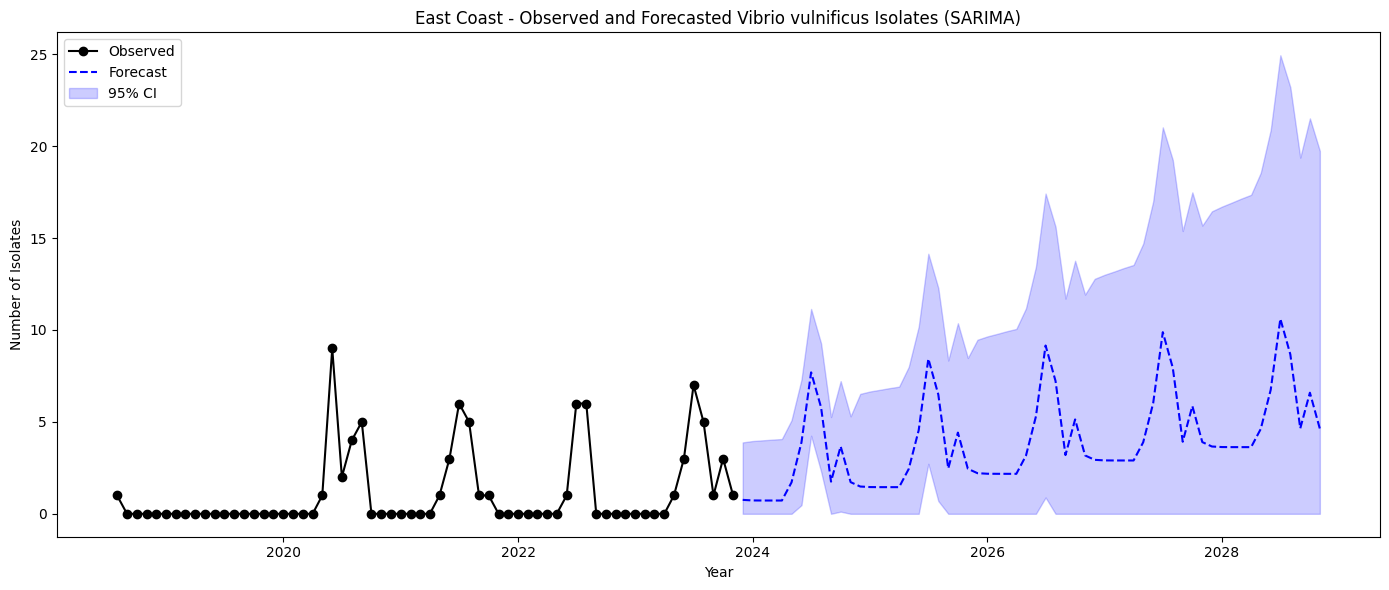

In [11]:
# Visualizing Historical Data with forecast data East Coast
# Step 1: Obtain data
github = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df = pd.read_csv(github)

# Step 2: Filter and aggregate data for East region
df_east = df[df['region'] == 'East']
df_east['Date'] = pd.to_datetime(df_east[['Year', 'Month']].assign(DAY=1))
east_monthly = df_east.groupby('Date')['Number_of_isolates'].sum().reset_index()
east_series = east_monthly.set_index('Date')['Number_of_isolates'].asfreq('MS').fillna(0)

# Step 3: Fit SARIMA model to entire East Coast data
sarima_model = SARIMAX(
    east_series,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Step 4: Forecast 60 months into the future
forecast_steps = 60
forecast_result = sarima_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean.clip(lower=0)
forecast_ci = forecast_result.conf_int().clip(lower=0)

# Step 5: Create future date range and organize forecast DataFrame
last_date = east_series.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Region': 'East',
    'Forecast': forecast_mean.values,
    'Lower_CI': forecast_ci.iloc[:, 0].astype(float).values,
    'Upper_CI': forecast_ci.iloc[:, 1].astype(float).values
})

# Step 6: Merge historical and forecast data
historical_df = east_series.reset_index().rename(columns={'Number_of_isolates': 'Observed'})
historical_df['Region'] = 'East'

merged_df = pd.merge(historical_df, forecast_df, on=['Date', 'Region'], how='outer')
merged_df['Forecast'] = pd.to_numeric(merged_df['Forecast'], errors='coerce')
merged_df['Lower_CI'] = pd.to_numeric(merged_df['Lower_CI'], errors='coerce')
merged_df['Upper_CI'] = pd.to_numeric(merged_df['Upper_CI'], errors='coerce')
merged_df['Observed'] = pd.to_numeric(merged_df['Observed'], errors='coerce')
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')

# Step 7: Drop rows with NaNs in confidence intervals (for plotting)
plot_df = merged_df.dropna(subset=['Lower_CI', 'Upper_CI', 'Forecast', 'Date'])

# Step 8: Plot
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['Observed'], label='Observed', color='black', marker='o')
plt.plot(merged_df['Date'], merged_df['Forecast'], label='Forecast', linestyle='--', color='blue')
plt.fill_between(
    plot_df['Date'].values,
    plot_df['Lower_CI'].astype('float64').values,
    plot_df['Upper_CI'].astype('float64').values,
    color='blue', alpha=0.2, label='95% CI'
)

plt.title("East Coast - Observed and Forecasted Vibrio vulnificus Isolates (SARIMA)")
plt.xlabel("Year")
plt.ylabel("Number of Isolates")
plt.legend()
plt.tight_layout()
plt.show()

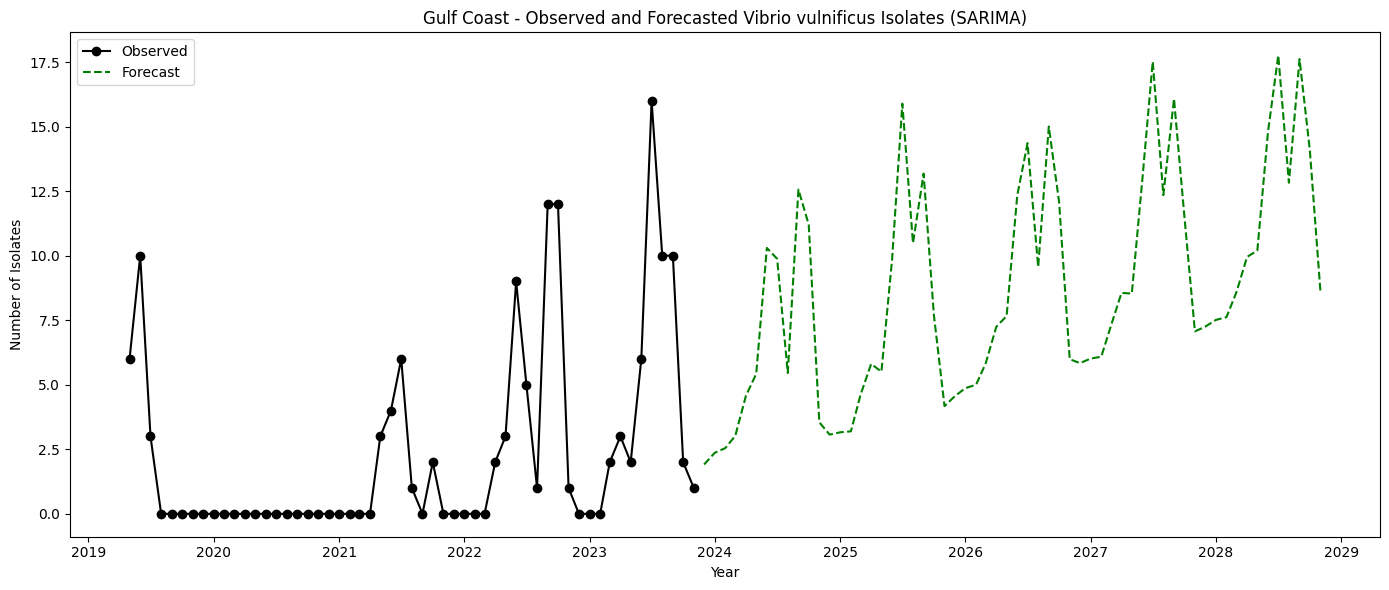

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Load and preprocess the dataset
github = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df = pd.read_csv(github)
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

# Step 2: Filter and aggregate data for Gulf region
df_gulf = df[df['region'] == 'Gulf']
gulf_monthly = df_gulf.groupby('Date')['Number_of_isolates'].sum().reset_index()
gulf_series = gulf_monthly.set_index('Date')['Number_of_isolates'].asfreq('MS').fillna(0)

# Step 3: Fit SARIMA model to entire Gulf Coast data
sarima_model = SARIMAX(
    gulf_series,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Step 4: Forecast 60 months into the future
forecast_steps = 60
forecast_result = sarima_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean.clip(lower=0)
forecast_ci = forecast_result.conf_int().clip(lower=0)

# Step 5: Create future date range and organize forecast DataFrame
last_date = gulf_series.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Region': 'Gulf',
    'Forecast': forecast_mean.values,
    'Lower_CI': forecast_ci.iloc[:, 0].astype(float).values,
    'Upper_CI': forecast_ci.iloc[:, 1].astype(float).values
})

# Step 6: Merge historical and forecast data
historical_df = gulf_series.reset_index().rename(columns={'Number_of_isolates': 'Observed'})
historical_df['Region'] = 'Gulf'

merged_df = pd.merge(historical_df, forecast_df, on=['Date', 'Region'], how='outer')
merged_df['Forecast'] = pd.to_numeric(merged_df['Forecast'], errors='coerce')
merged_df['Lower_CI'] = pd.to_numeric(merged_df['Lower_CI'], errors='coerce')
merged_df['Upper_CI'] = pd.to_numeric(merged_df['Upper_CI'], errors='coerce')
merged_df['Observed'] = pd.to_numeric(merged_df['Observed'], errors='coerce')
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')

# Step 7: Drop rows with NaNs in confidence intervals (for plotting)
plot_df = merged_df.dropna(subset=['Lower_CI', 'Upper_CI', 'Forecast', 'Date'])

# Step 8: Plot
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['Observed'], label='Observed', color='black', marker='o')
plt.plot(merged_df['Date'], merged_df['Forecast'], label='Forecast', linestyle='--', color='green')
#plt.fill_between(
    #plot_df['Date'].values,
    #plot_df['Lower_CI'].astype('float64').values,
    #plot_df['Upper_CI'].astype('float64').values,
    #color='green', alpha=0.2, label='95% CI')

plt.title("Gulf Coast - Observed and Forecasted Vibrio vulnificus Isolates (SARIMA)")
plt.xlabel("Year")
plt.ylabel("Number of Isolates")
plt.legend()
plt.tight_layout()
plt.show()


# Sea Surface Temperature

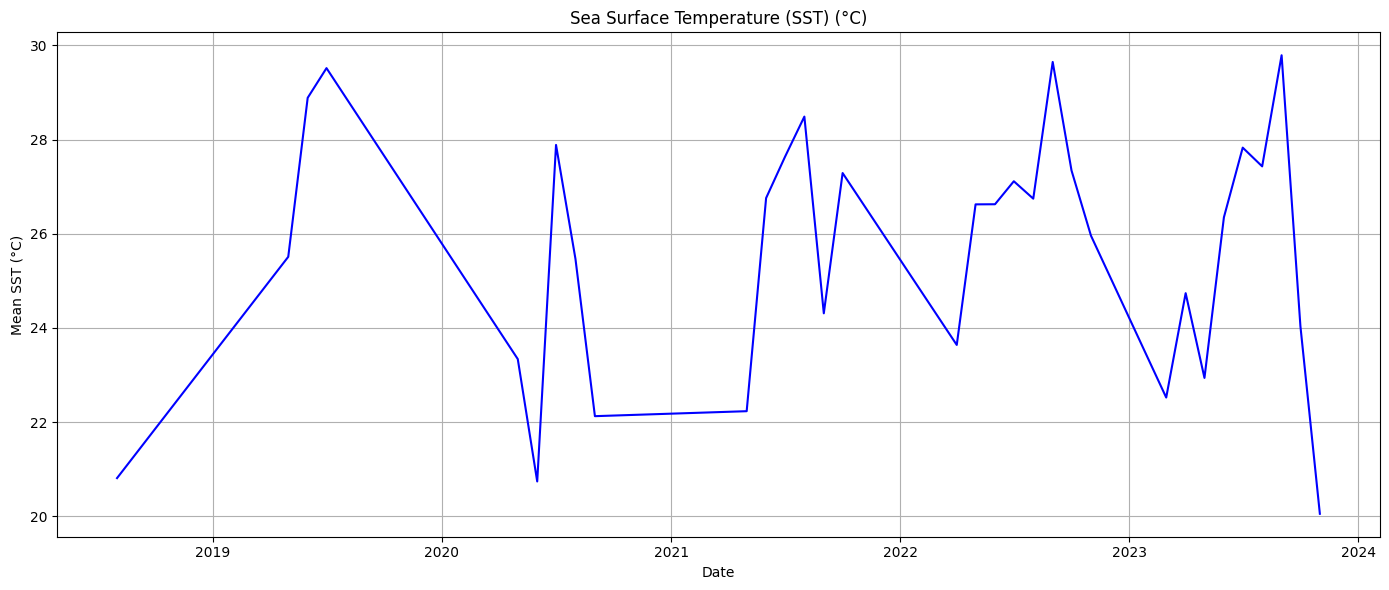

In [13]:
import pandas as pd

# Load the SSS data from the provided GitHub link
url = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df_sss = pd.read_csv(url)

# Display the first few rows to inspect the data
df_sss.head()

import matplotlib.pyplot as plt
import seaborn as sns

# Convert Month and Year into a datetime column
df_sss['Date'] = pd.to_datetime(df_sss[['Year', 'Month']].assign(DAY=1))

# Group by date and state, then calculate the mean SSS
sss_time_series = (
    df_sss.groupby(['Date'])['sst']
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=sss_time_series, x='Date', y='sst', color = "blue")
plt.title('Sea Surface Temperature (SST) (°C)')
plt.xlabel('Date')
plt.ylabel('Mean SST (°C)')
plt.tight_layout()
plt.grid(True)
plt.show()

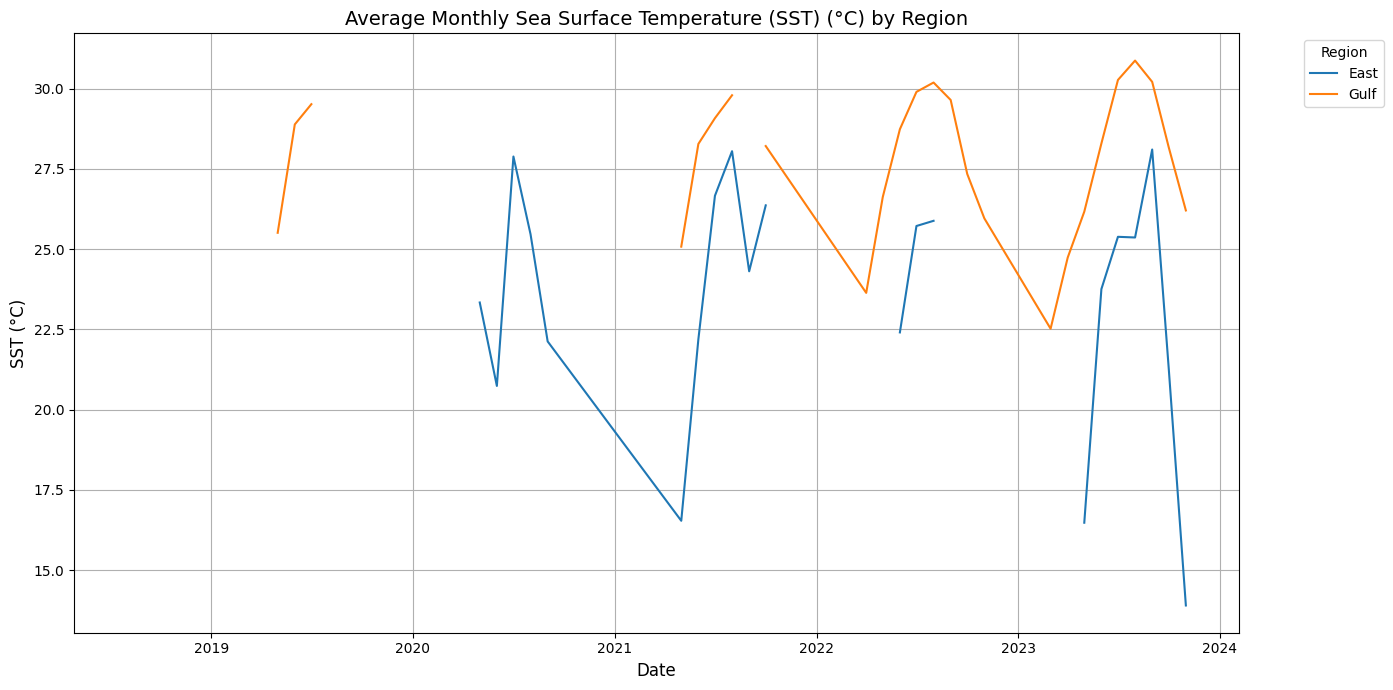

In [14]:
#Load Data
url = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df_region = pd.read_csv(url)

# Create date column
df_region["date"] = pd.to_datetime(df_region[["Year", "Month"]].assign(DAY=1))

# Group by date and region and calculate average SST
regional_sst_avg = df_region.groupby(["date", "region"])["sst"].mean().reset_index()

# Pivot for plotting
sst_region_pivot = regional_sst_avg.pivot(index="date", columns="region", values="sst")

# Plot
plt.figure(figsize=(14, 7))
for region in sst_region_pivot.columns:
    plt.plot(sst_region_pivot.index, sst_region_pivot[region], label=region)

plt.title("Average Monthly Sea Surface Temperature (SST) (°C) by Region", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("SST (°C)", fontsize=12)
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Import Libraries
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Reload the uploaded file
url = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df = pd.read_csv(url)

# Aggregate to national average SST by date
df_national = df.groupby(['Year', 'Month']).agg({'sst': 'mean'}).reset_index()
df_national['date'] = pd.to_datetime(df_national[['Year', 'Month']].assign(day=1))
df_national.set_index('date', inplace=True)
sst_series = df_national['sst']

# Split into train/test
train_size = int(len(sst_series) * 0.85)
train, test = sst_series[:train_size], sst_series[train_size:]

# SARIMA
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)
sarima_forecast = sarima_model.forecast(steps=len(test))

# ARIMA
arima_model = ARIMA(train, order=(1, 1, 1)).fit()
arima_forecast = arima_model.forecast(steps=len(test))

# Prophet
df_prophet = df_national[['sst']].reset_index().rename(columns={'date': 'ds', 'sst': 'y'})
prophet = Prophet()
prophet.fit(df_prophet[:train_size])
future = prophet.make_future_dataframe(periods=len(test), freq='MS')
forecast_prophet = prophet.predict(future)
prophet_forecast = forecast_prophet.iloc[-len(test):]['yhat'].values

# Random Forest
df_national['sst_lag1'] = df_national['sst'].shift(1)
df_national['sst_lag12'] = df_national['sst'].shift(12)
df_rf = df_national.dropna()

X = df_rf[['sst_lag1', 'sst_lag12']]
y = df_rf['sst']
X_train, X_test = X.iloc[:train_size-12], X.iloc[train_size-12:]
y_train, y_test = y.iloc[:train_size-12], y.iloc[train_size-12:]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_forecast = rf_model.predict(X_test)

# Align all outputs for fair comparison
min_len = min(len(test), len(y_test), len(prophet_forecast))
test = test[:min_len]
arima_forecast = arima_forecast[:min_len]
sarima_forecast = sarima_forecast[:min_len]
prophet_forecast = prophet_forecast[:min_len]
rf_forecast = rf_forecast[:min_len]
y_test = y_test[:min_len]

# Compare Model Metrics
results = {
    'Model': ['SARIMA', 'ARIMA', 'Prophet', 'Random Forest'],
    'MAE': [
        mean_absolute_error(test, sarima_forecast),
        mean_absolute_error(test, arima_forecast),
        mean_absolute_error(test, prophet_forecast),
        mean_absolute_error(y_test, rf_forecast)
    ],
    'RMSE': [
        sqrt(mean_squared_error(test, sarima_forecast)),
        sqrt(mean_squared_error(test, arima_forecast)),
        sqrt(mean_squared_error(test, prophet_forecast)),
        sqrt(mean_squared_error(y_test, rf_forecast))
    ]
}

results_df = pd.DataFrame(results)
print("\n",results_df)

#Export Validation as a CSV file
results_df.to_csv("sst_model_validation_scores_comparasion.csv", index=False)
from google.colab import files
#files.download("sst_model_validation_scores_comparasion.csv")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retu


            Model       MAE      RMSE
0         SARIMA  4.011237  4.515250
1          ARIMA  3.034326  3.411092
2        Prophet  2.529457  2.680887
3  Random Forest  2.967671  3.434142


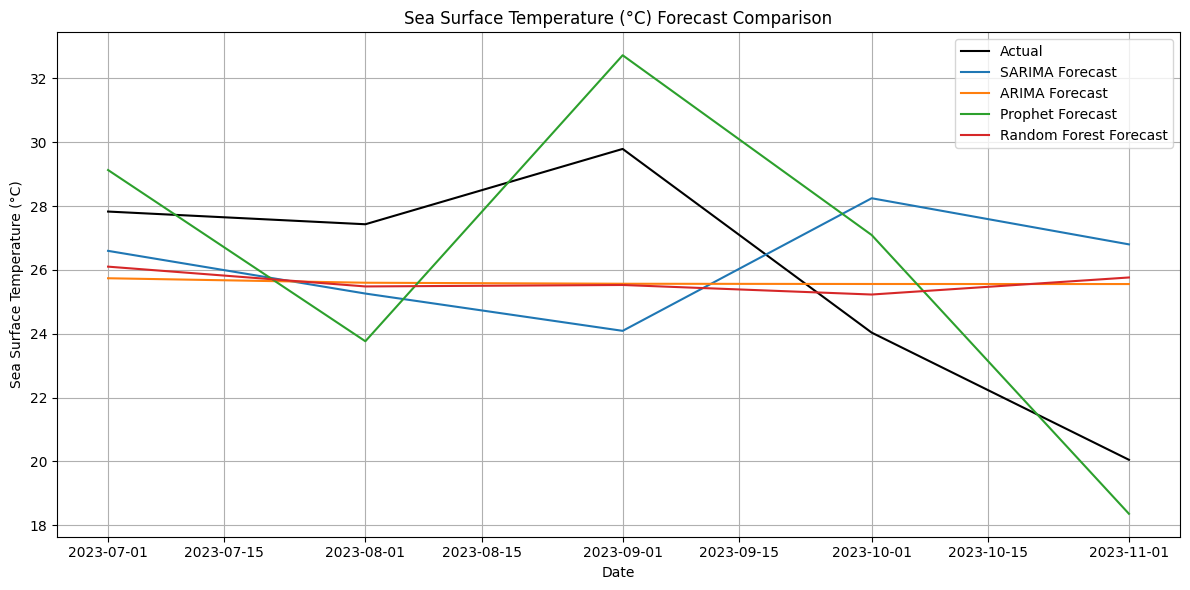

In [16]:
# Forecast Comparison Plot
plt.figure(figsize=(12,6))
plt.plot(test.index[:min_len], test[:min_len], label='Actual', color='black')
plt.plot(test.index[:min_len], sarima_forecast, label='SARIMA Forecast')
plt.plot(test.index[:min_len], arima_forecast, label='ARIMA Forecast')
plt.plot(test.index[:min_len], prophet_forecast, label='Prophet Forecast')
plt.plot(test.index[:min_len], rf_forecast, label='Random Forest Forecast')
plt.legend()
plt.title("Sea Surface Temperature (°C) Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Sea Surface Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc966ezfj/pwrb3xxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc966ezfj/ekxs6fue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39994', 'data', 'file=/tmp/tmpc966ezfj/pwrb3xxz.json', 'init=/tmp/tmpc966ezfj/ekxs6fue.json', 'output', 'file=/tmp/tmpc966ezfj/prophet_modelx324wb7c/prophet_model-20250503200914.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:09:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:09:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


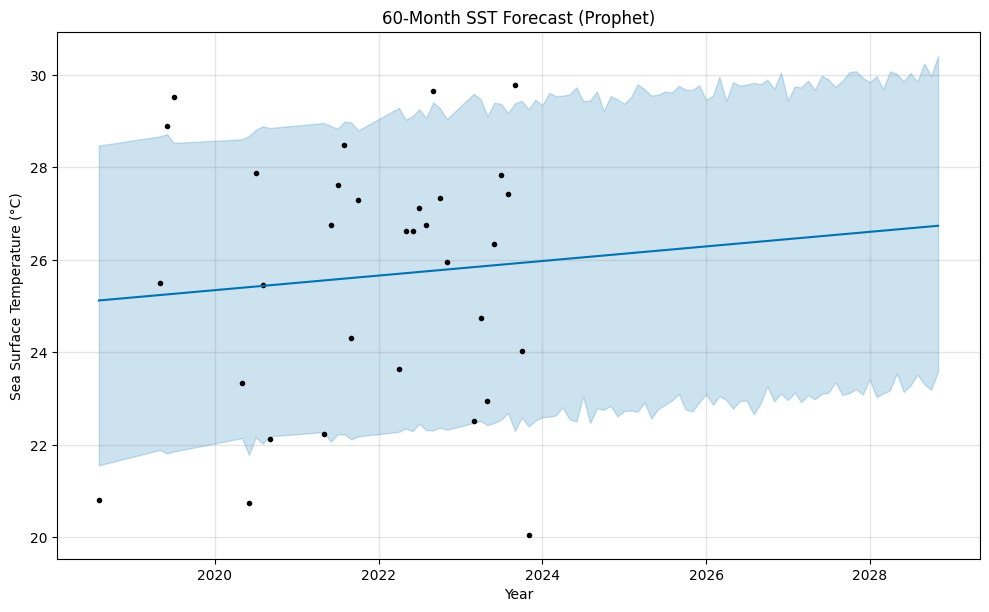

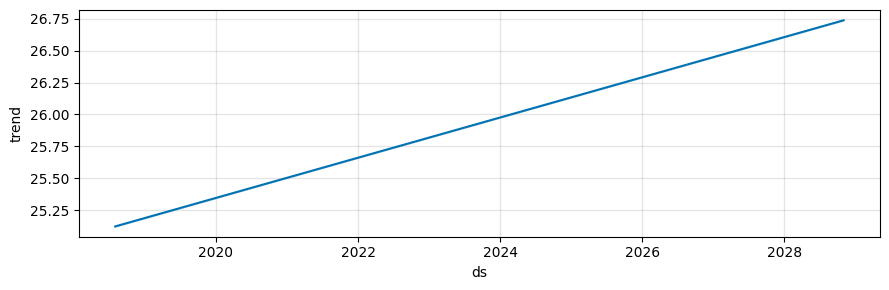

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load and prep the dataset
url = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df = pd.read_csv(url)

# Group by year + month to get national average SST
df_national = df.groupby(['Year', 'Month']).agg({'sst': 'mean'}).reset_index()
df_national['date'] = pd.to_datetime(df_national[['Year', 'Month']].assign(day=1))
df_prophet = df_national[['date', 'sst']].rename(columns={'date': 'ds', 'sst': 'y'})

df_prophet
# Build Prophet model with better constraints
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05  # smaller = smoother trend
)

# Add custom monthly seasonality (e.g., SST changes through the year)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=3)

# Fit the model
model.fit(df_prophet)

# Create 60-month forecast
future = model.make_future_dataframe(periods=60, freq='MS')
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title('60-Month SST Forecast (Prophet)')
plt.xlabel('Year')
plt.ylabel('Sea Surface Temperature (°C)')
plt.grid(True)
plt.show()

# Plot trend and seasonal components
fig2 = model.plot_components(forecast)
plt.show()

# Save and Export Forecast

# Rename columns
forecast_renamed = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(
    columns={
        'ds': 'date',
        'yhat': 'sst',
        'yhat_lower': 'Lower 95% CI',
        'yhat_upper': 'Upper 95% CI'
    }
)

# Preview the DataFrame
forecast_renamed.isna().sum()

# Export to CSV
forecast_renamed.to_csv("prophet_sst_forecast.csv", index=False)

#from google.colab import files
files.download("prophet_sst_forecast.csv")

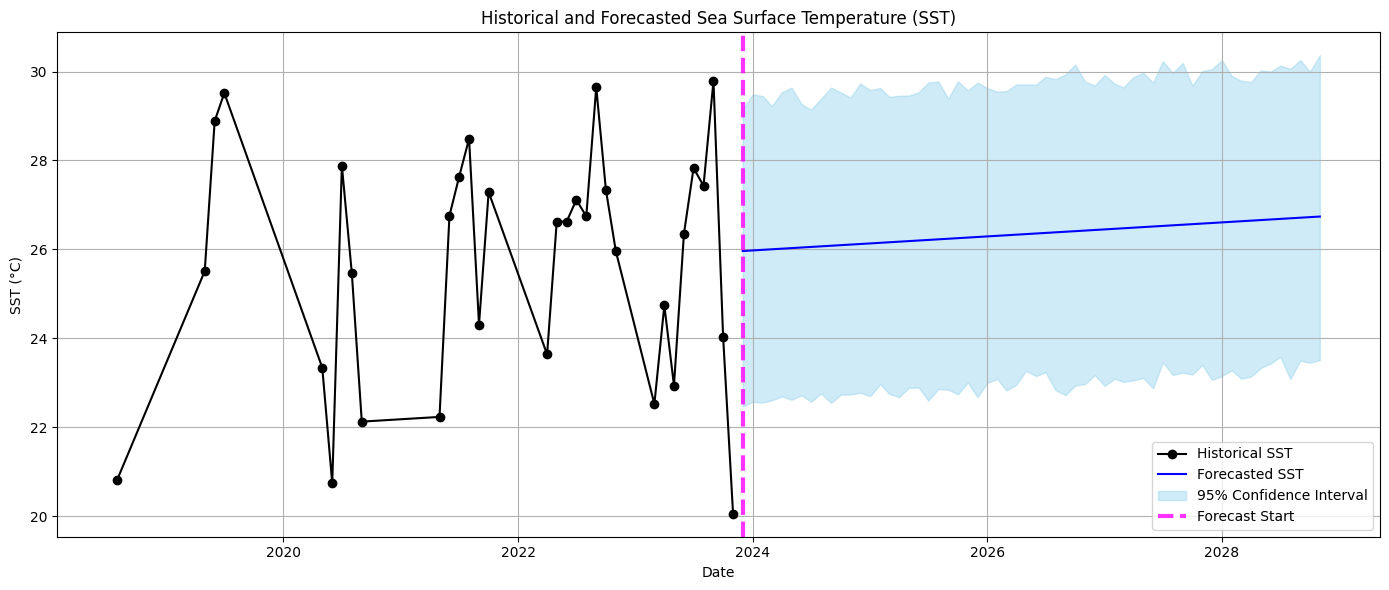

In [18]:
# Visualize Histroic and Forecasted data

import pandas as pd
import matplotlib.pyplot as plt

# === Load Data ===
# Historical SST data
historical_path = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
historical_df = pd.read_csv(historical_path)
historical_df['date'] = pd.to_datetime(historical_df[['Year', 'Month']].assign(day=1))
historical_sst = historical_df.groupby('date')['sst'].mean().reset_index()

# Forecasted SST data (already renamed as: date, sst, Lower 95% CI, Upper 95% CI)
forecast_path = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/prophet_sst_forecast.csv"
forecast_df = pd.read_csv(forecast_path)
forecast_df['date'] = pd.to_datetime(forecast_df['date'])


# === Preprocessing ===
# Ensure numeric CI columns
forecast_df['Lower 95% CI'] = pd.to_numeric(forecast_df['Lower 95% CI'], errors='coerce')
forecast_df['Upper 95% CI'] = pd.to_numeric(forecast_df['Upper 95% CI'], errors='coerce')
forecast_df['sst'] = pd.to_numeric(forecast_df['sst'], errors='coerce')
forecast_df.dropna(subset=['sst', 'Lower 95% CI', 'Upper 95% CI'], inplace=True)

# Only show forecasted SST *after* the last historical date
last_hist_date = historical_sst['date'].max()
forecast_only = forecast_df[forecast_df['date'] > last_hist_date]
forecast_only

# === Plot ===
plt.figure(figsize=(14, 6))

# Historical SST
plt.plot(historical_sst['date'], historical_sst['sst'], label='Historical SST', color='black', marker='o')

# Forecasted SST (only after last observed date)
plt.plot(forecast_only['date'], forecast_only['sst'], label='Forecasted SST', color='blue')

# 95% Confidence Interval for forecast only
plt.fill_between(forecast_only['date'].values,
                 forecast_only['Lower 95% CI'].values,
                 forecast_only['Upper 95% CI'].values,
                 color='skyblue', alpha=0.4, label='95% Confidence Interval')


# Vertical line at transition
plt.axvline(x=forecast_only['date'].min(), color='magenta', linestyle='--', label='Forecast Start', lw = 3, alpha = 0.8)

# Labels and formatting
plt.title("Historical and Forecasted Sea Surface Temperature (SST)")
plt.xlabel("Date")
plt.ylabel("SST (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

# === Load historical SST ===
historical_path = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
historical_df = pd.read_csv(historical_path)
historical_df['date'] = pd.to_datetime(historical_df[['Year', 'Month']].assign(day=1))
historical_sst = historical_df.groupby('date')['sst'].mean().reset_index()

# Rename columns to match forecast format
historical_sst_renamed = historical_sst.rename(columns={'sst': 'SST'})
historical_sst_renamed['type'] = 'historical'
historical_sst_renamed['Lower 95% CI'] = None
historical_sst_renamed['Upper 95% CI'] = None

# === Load forecasted SST ===
forecast_path = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/prophet_sst_forecast.csv"
forecast_df = pd.read_csv(forecast_path)
forecast_df['date'] = pd.to_datetime(forecast_df['date'])

# Ensure numeric conversion in case of format issues
forecast_df['Lower 95% CI'] = pd.to_numeric(forecast_df['Lower 95% CI'], errors='coerce')
forecast_df['Upper 95% CI'] = pd.to_numeric(forecast_df['Upper 95% CI'], errors='coerce')
forecast_df['sst'] = pd.to_numeric(forecast_df['sst'], errors='coerce')

# Format forecasted data
forecast_only = forecast_df[['date', 'sst', 'Lower 95% CI', 'Upper 95% CI']].rename(columns={'sst': 'SST'})
forecast_only['type'] = 'forecast'

# === Combine historical and forecast ===
combined_df = pd.concat([historical_sst_renamed, forecast_only], ignore_index=True)

# === Export to CSV ===
combined_df.to_csv("combined_sst_historical_forecast.csv", index=False)

# === Download File ===
# import io
# from google.colab import files
# files.download("combined_sst_historical_forecast.csv")


<ipython-input-19-feaf35d54e54>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([historical_sst_renamed, forecast_only], ignore_index=True)


# Sea Surface Salinity

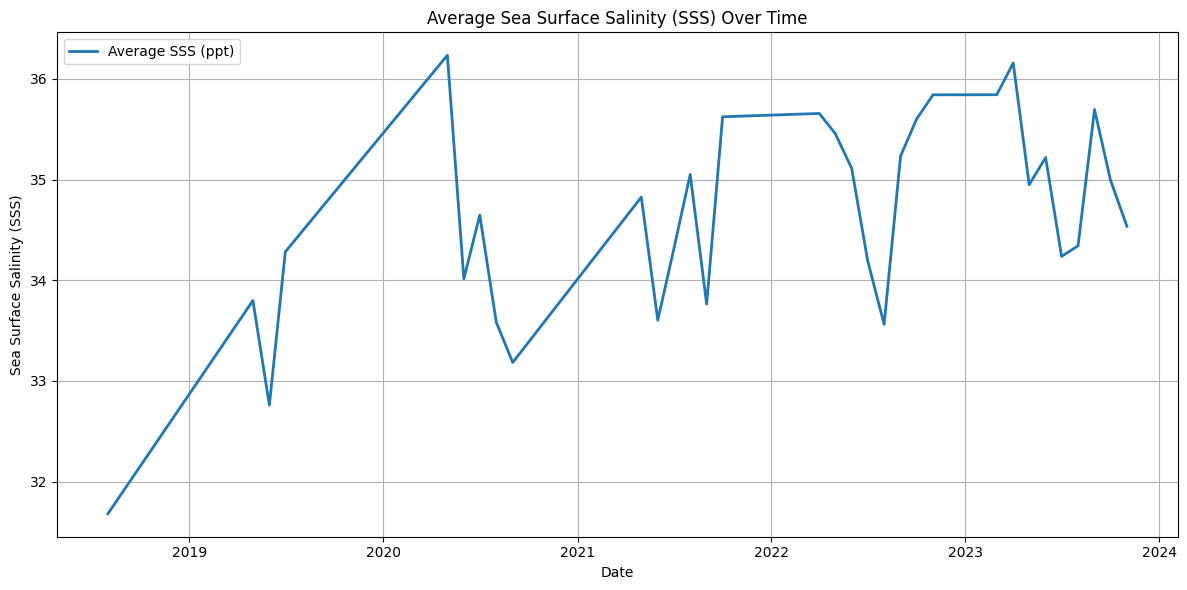

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df = pd.read_csv(url)

# Create a 'Date' column for time series visualization
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Group data by date and compute average salinity (sss)
sss_time_series = df.groupby('Date')['sss'].mean().reset_index()

# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(sss_time_series['Date'], sss_time_series['sss'], label='Average SSS (ppt)', linewidth=2)
plt.title('Average Sea Surface Salinity (SSS) Over Time')
plt.xlabel('Date')
plt.ylabel('Sea Surface Salinity (SSS)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



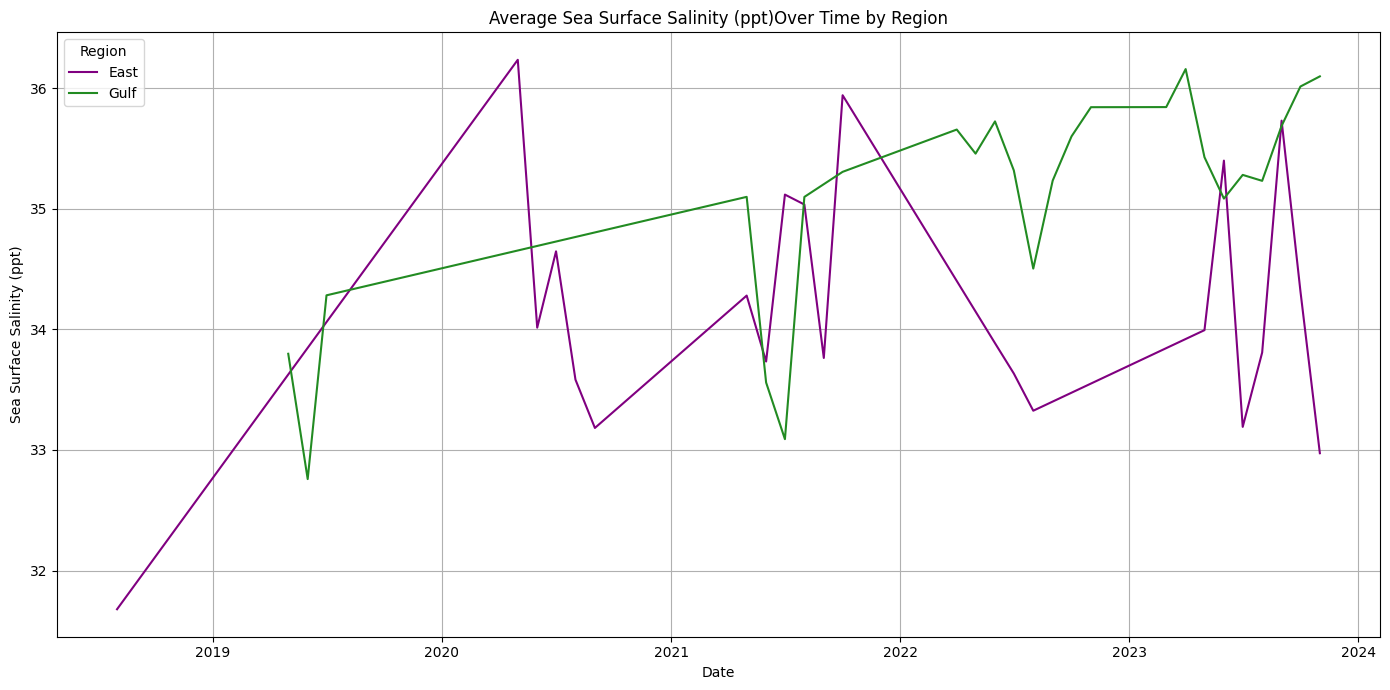

In [21]:
# Compare Regions

# Load the region-based dataset
url = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df_region = pd.read_csv(url)

# Create a 'Date' column for time series visualization
df_region['Date'] = pd.to_datetime(df_region[['Year', 'Month']].assign(DAY=1))

# Group by region and date, then calculate average salinity
sss_by_region = df_region.groupby(['region', 'Date'])['sss'].mean().reset_index()

# Plotting

custom_colors = {
    'East': 'purple',
    'Gulf': 'forestgreen'
}

plt.figure(figsize=(14, 7))
for region in sss_by_region['region'].unique():
    region_data = sss_by_region[sss_by_region['region'] == region]
    plt.plot(region_data['Date'], region_data['sss'], label=region, color = custom_colors.get(region))

plt.title('Average Sea Surface Salinity (ppt)Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Sea Surface Salinity (ppt)')
plt.legend(title='Region')
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
#Model Validation

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from prophet import Prophet

# Load dataset
url = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df_region = pd.read_csv(url)
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
sss_time_series = df.groupby('date')['sss'].mean().reset_index()

# Time series setup
sss_series = sss_time_series.set_index('date')['sss']
train_size = int(len(sss_series) * 0.8)
train, test = sss_series[:train_size], sss_series[train_size:]
forecast_steps = len(test)

# ARIMA
arima_model = ARIMA(train, order=(1,1,1))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=forecast_steps)

# SARIMA
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# Prophet
prophet_df = sss_time_series.rename(columns={'date': 'ds', 'sss': 'y'})
prophet_train = prophet_df.iloc[:train_size]
prophet_model = Prophet()
prophet_model.fit(prophet_train)
prophet_future = prophet_df.iloc[train_size:][['ds']]
prophet_forecast = prophet_model.predict(prophet_future)['yhat'].values

# Random Forest
def create_lag_features(series, lags=12):
    df_lag = pd.DataFrame({'y': series})
    for lag in range(1, lags + 1):
        df_lag[f'lag_{lag}'] = series.shift(lag)
    df_lag.dropna(inplace=True)
    return df_lag

rf_data = create_lag_features(sss_series)
X = rf_data.drop(columns='y')
y = rf_data['y']
X_train, X_test = X.iloc[:train_size - 12], X.iloc[train_size - 12:]
y_train, y_test = y.iloc[:train_size - 12], y.iloc[train_size - 12:]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_forecast = rf_model.predict(X_test)

# Compare Model Metrics
results = {
    'Model': ['SARIMA', 'ARIMA', 'Prophet', 'Random Forest'], # Add 'Prophet' if you enable it
    'MAE': [
        mean_absolute_error(test, sarima_forecast),
        mean_absolute_error(test, arima_forecast),
        mean_absolute_error(test, prophet_forecast),
        mean_absolute_error(y_test, rf_forecast)
    ],
    'RMSE': [
        sqrt(mean_squared_error(test, sarima_forecast)),
        sqrt(mean_squared_error(test, arima_forecast)),
        sqrt(mean_squared_error(test, prophet_forecast)),
        sqrt(mean_squared_error(y_test, rf_forecast))
    ]
}

results_df = pd.DataFrame(results)
print('\n', results_df)

results_df.to_csv("sss_model_validation_scores_comparasion.csv", index=False)
from google.colab import files
files.download("sss_model_validation_scores_comparasion.csv")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


            Model       MAE      RMSE
0         SARIMA  1.970371  2.191521
1          ARIMA  0.823032  0.939232
2        Prophet  1.223044  1.914710
3  Random Forest  0.582316  0.712898


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

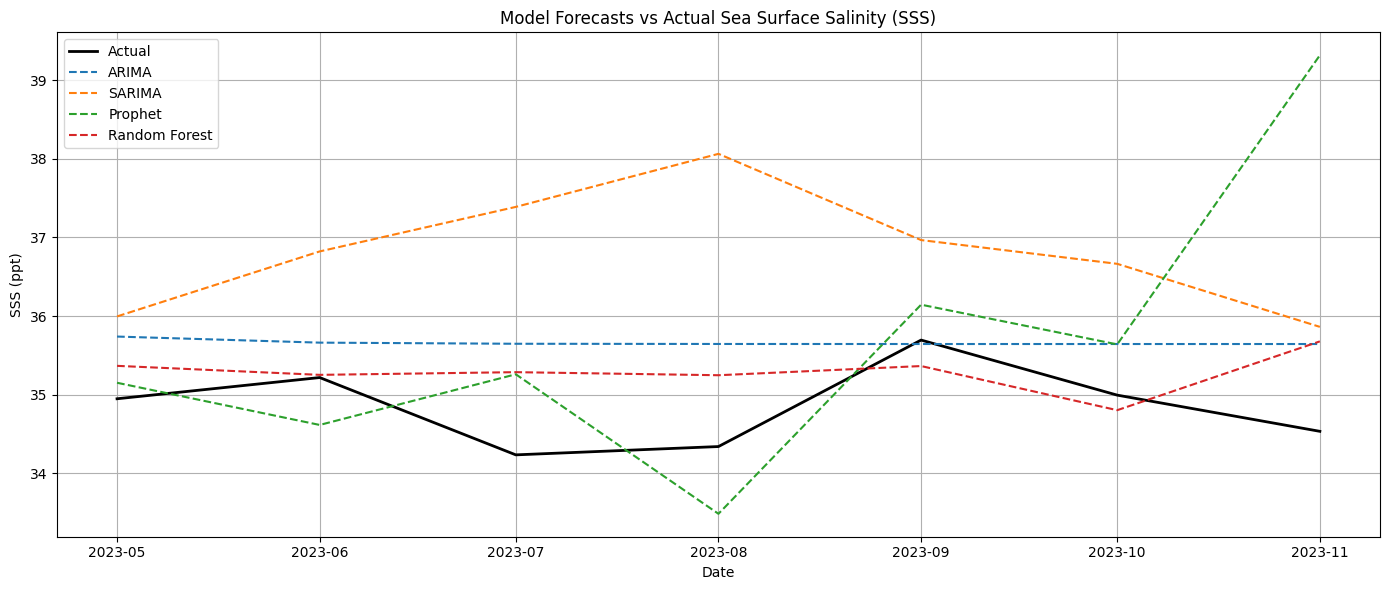

In [23]:
import matplotlib.pyplot as plt

# Build full results_df for plotting
results_df = pd.DataFrame({
    'date': test.index,
    'actual': test.values,
    'ARIMA': arima_forecast.values,
    'SARIMA': sarima_forecast.values,
    'Prophet': prophet_forecast,
    'Random Forest': rf_forecast
})

# Plot
plt.figure(figsize=(14, 6))
plt.plot(results_df['date'], results_df['actual'], label='Actual', color='black', linewidth=2)
plt.plot(results_df['date'], results_df['ARIMA'], label='ARIMA', linestyle='--')
plt.plot(results_df['date'], results_df['SARIMA'], label='SARIMA', linestyle='--')
plt.plot(results_df['date'], results_df['Prophet'], label='Prophet', linestyle='--')  # Uncomment locally
plt.plot(results_df['date'], results_df['Random Forest'], label='Random Forest', linestyle='--')

plt.title('Model Forecasts vs Actual Sea Surface Salinity (SSS)')
plt.xlabel('Date')
plt.ylabel('SSS (ppt)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


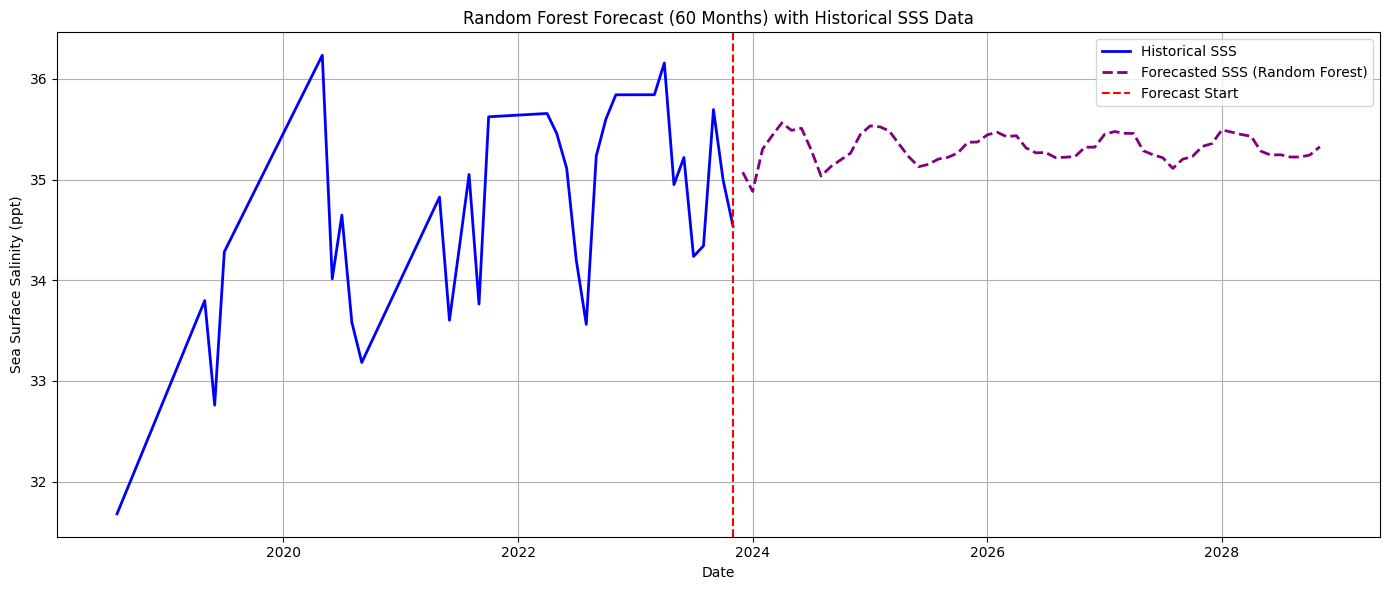

,date,sss_forecast
0,2018-08-01,31.679759
1,2019-05-01,33.797745
2,2019-06-01,32.758971
3,2019-07-01,34.282280
4,2020-05-01,36.234785
...,...,...
55,2028-07-01,35.246833
56,2028-08-01,35.223836
57,2028-09-01,35.224019
58,2028-10-01,35.244050


In [24]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Rebuild full dataset with lag features and seasonal indicators
sss_series = sss_time_series.set_index('date')['sss']
data = pd.DataFrame({'y': sss_series})
for lag in range(1, 13):
    data[f'lag_{lag}'] = data['y'].shift(lag)
data['month'] = data.index.month
data.dropna(inplace=True)

# Split into features and target
X = data.drop(columns='y')
y = data['y']

# Train on full data
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X, y)

# Forecast the next 60 months
last_known = data.copy()
forecast_months = 60
predictions = []

for i in range(forecast_months):
    last_row = last_known.iloc[-1]
    new_month = (last_row.name.month % 12) + 1
    lags = last_known['y'].iloc[-12:].values[::-1]  # last 12 months in reverse order
    new_input = dict(zip([f'lag_{j+1}' for j in range(12)], lags))
    new_input['month'] = new_month
    new_input_df = pd.DataFrame([new_input])
    pred = rf_model.predict(new_input_df)[0]
    predictions.append(pred)

    # Append the new forecast to the end of last_known
    next_date = last_known.index[-1] + pd.DateOffset(months=1)
    row = pd.Series({'y': pred, **new_input}, name=next_date)
    last_known = pd.concat([last_known, pd.DataFrame([row])])

# Build forecast DataFrame
forecast_dates = pd.date_range(start=last_known.index[-forecast_months], periods=forecast_months, freq='MS')
forecast_df = pd.DataFrame({'date': forecast_dates, 'sss_forecast': predictions})

# Combine historical and forecast for plotting
combined_df = pd.concat([
    sss_time_series.rename(columns={'sss': 'sss_forecast'})[['date', 'sss_forecast']],
    forecast_df
])

# Split historical and forecasted data for separate color plotting
historical_df = combined_df[combined_df['date'] <= sss_time_series['date'].max()]
future_df = combined_df[combined_df['date'] > sss_time_series['date'].max()]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(historical_df['date'], historical_df['sss_forecast'], label='Historical SSS', color='blue', linewidth=2)
plt.plot(future_df['date'], future_df['sss_forecast'], label='Forecasted SSS (Random Forest)', color='purple', linestyle='--', linewidth=2)
plt.axvline(x=sss_time_series['date'].max(), color='red', linestyle='--', label='Forecast Start')
plt.title('Random Forest Forecast (60 Months) with Historical SSS Data')
plt.xlabel('Date')
plt.ylabel('Sea Surface Salinity (ppt)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from IPython.display import display
display(combined_df)


In [25]:
# Export Data
# combined_df.to_csv("random_forest_sss_forecast.csv", index=False)

# Download it
# from google.colab import files
# files.download("random_forest_sss_forecast.csv")

60 Month Forecasting

<ipython-input-26-eb901f07d11f>:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='date', y='Number_of_isolates', hue='region', marker='o', ax=axs[1, 1], ci = None)


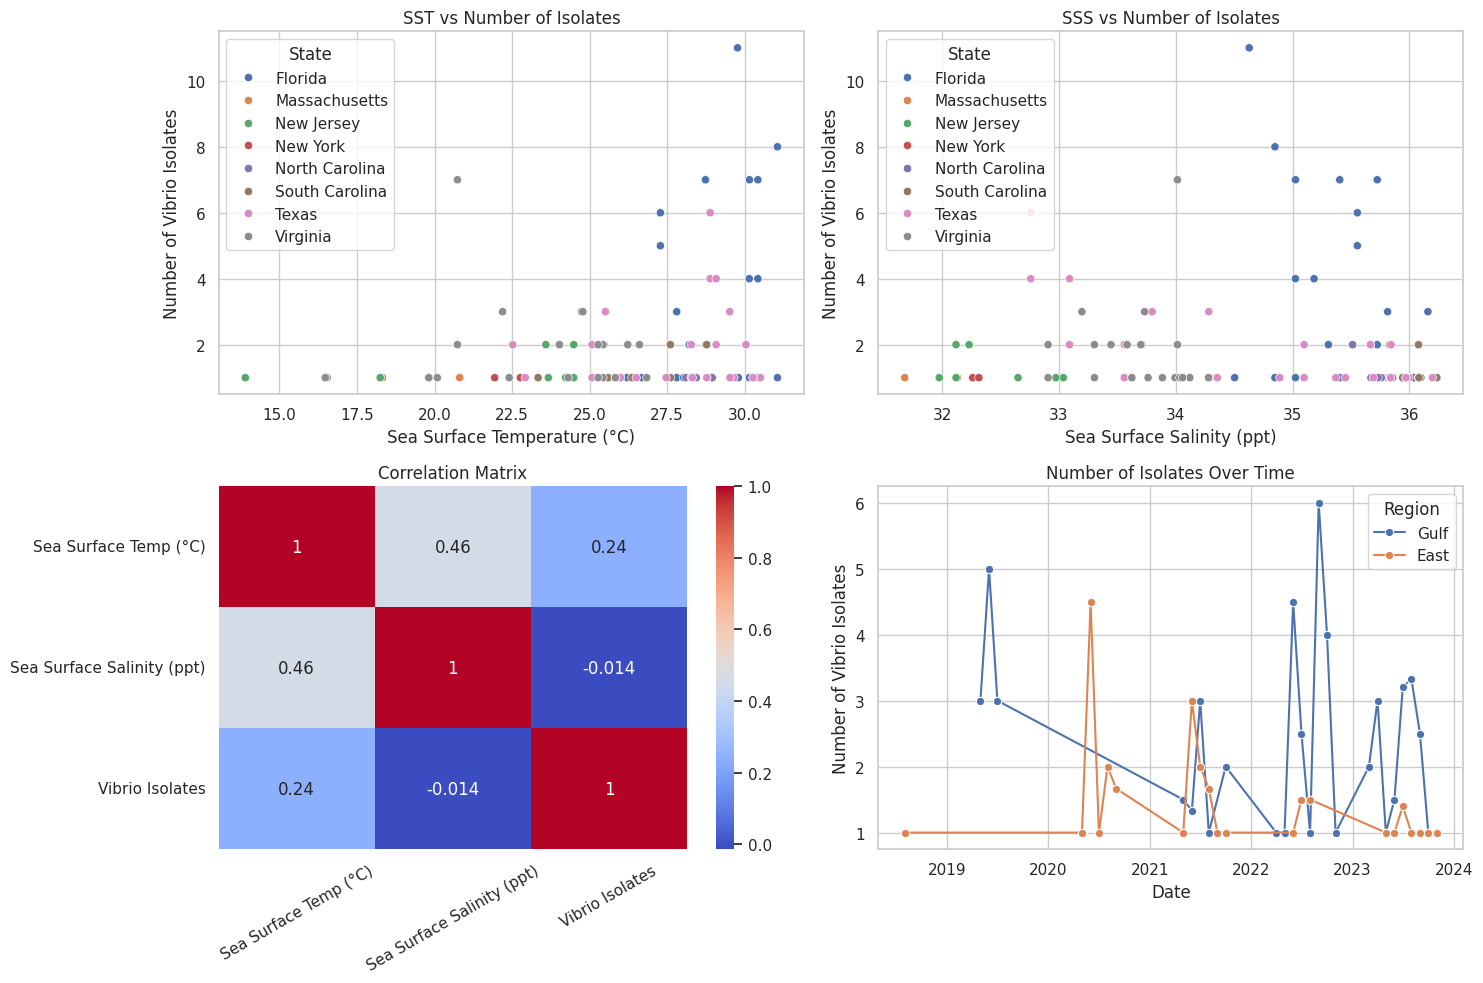

<Figure size 640x480 with 0 Axes>

In [26]:
# Visualizing the data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the historical data
url = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg_region.csv"
df = pd.read_csv(url)



# Create a datetime column for temporal visualizations
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

# Set up the visual style
sns.set(style="whitegrid")

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Scatter: SST vs Isolates
sns.scatterplot(data=df, x='sst', y='Number_of_isolates', hue='state_name', ax=axs[0, 0])
axs[0, 0].set_title('SST vs Number of Isolates')
axs[0, 0].set_xlabel('Sea Surface Temperature (°C)')
axs[0, 0].set_ylabel('Number of Vibrio Isolates')
axs[0, 0].legend(title='State')

# Scatter: SSS vs Isolates
sns.scatterplot(data=df, x='sss', y='Number_of_isolates', hue='state_name', ax=axs[0, 1])
axs[0, 1].set_title('SSS vs Number of Isolates')
axs[0, 1].set_xlabel('Sea Surface Salinity (ppt)')
axs[0, 1].set_ylabel('Number of Vibrio Isolates')
axs[0, 1].legend(title='State')

# Correlation Heatmap
corr = df[['sst', 'sss', 'Number_of_isolates']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axs[1, 0],
             xticklabels=['Sea Surface Temp (°C)', 'Sea Surface Salinity (ppt)', 'Vibrio Isolates'],
            yticklabels=['Sea Surface Temp (°C)', 'Sea Surface Salinity (ppt)', 'Vibrio Isolates'])
axs[1, 0].set_title('Correlation Matrix')
axs[1, 0].tick_params(axis='x', labelrotation=30)
axs[1, 0].tick_params(axis='y', labelrotation=0)

# Line plot
sns.lineplot(data=df, x='date', y='Number_of_isolates', hue='region', marker='o', ax=axs[1, 1], ci = None)
axs[1, 1].set_title('Number of Isolates Over Time')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Number of Vibrio Isolates')
axs[1, 1].legend(title='Region')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


plt.tight_layout()
plt.show()


In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Load the historical data
url = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg.csv"
df = pd.read_csv(url)

# Create a datetime column for temporal visualizations
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

# Prepare dataset
df_sorted = df.sort_values("date").copy()
df_sorted['sst_lag1'] = df_sorted['sst'].shift(1)
df_sorted['sss_lag1'] = df_sorted['sss'].shift(1)
df_model = df_sorted.dropna(subset=['sst_lag1', 'sss_lag1'])

# Features and target
X = df_model[['sst', 'sss', 'sst_lag1', 'sss_lag1']]
y = df_model['Number_of_isolates']

# TimeSeries cross-validation
tscv = TimeSeriesSplit(n_splits=5)
results = {
    'Model': [],
    'MAE': [],
    'RMSE': []
}

# SARIMAX (fitted once, not cross-validated due to stateful nature)
sarimax_model = SARIMAX(
    y, exog=X, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12), enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False)
sarimax_pred = sarimax_model.predict(start=0, end=len(y)-1, exog=X)
results['Model'].append('SARIMAX')
results['MAE'].append(mean_absolute_error(y, sarimax_pred))
results['RMSE'].append(np.sqrt(mean_squared_error(y, sarimax_pred)))

# Random Forest & XGBoost with CV
for model_name, model in {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror', random_state=42)
}.items():
    maes, rmses = [], []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        maes.append(mean_absolute_error(y_test, y_pred))
        rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    results['Model'].append(model_name)
    results['MAE'].append(np.mean(maes))
    results['RMSE'].append(np.mean(rmses))

# Present the results in a table
import pandas as pd

results_df = pd.DataFrame(results)
from IPython.display import display

display(results_df)

results_df.to_csv("sst_sss_model_validation_results.csv", index=False)

from google.colab import files
# files.download("sst_sss_model_validation_results.csv")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Model,MAE,RMSE
0,SARIMAX,1.272167,1.887603
1,Random Forest,1.436235,1.971722
2,XGBoost,1.486703,2.332631


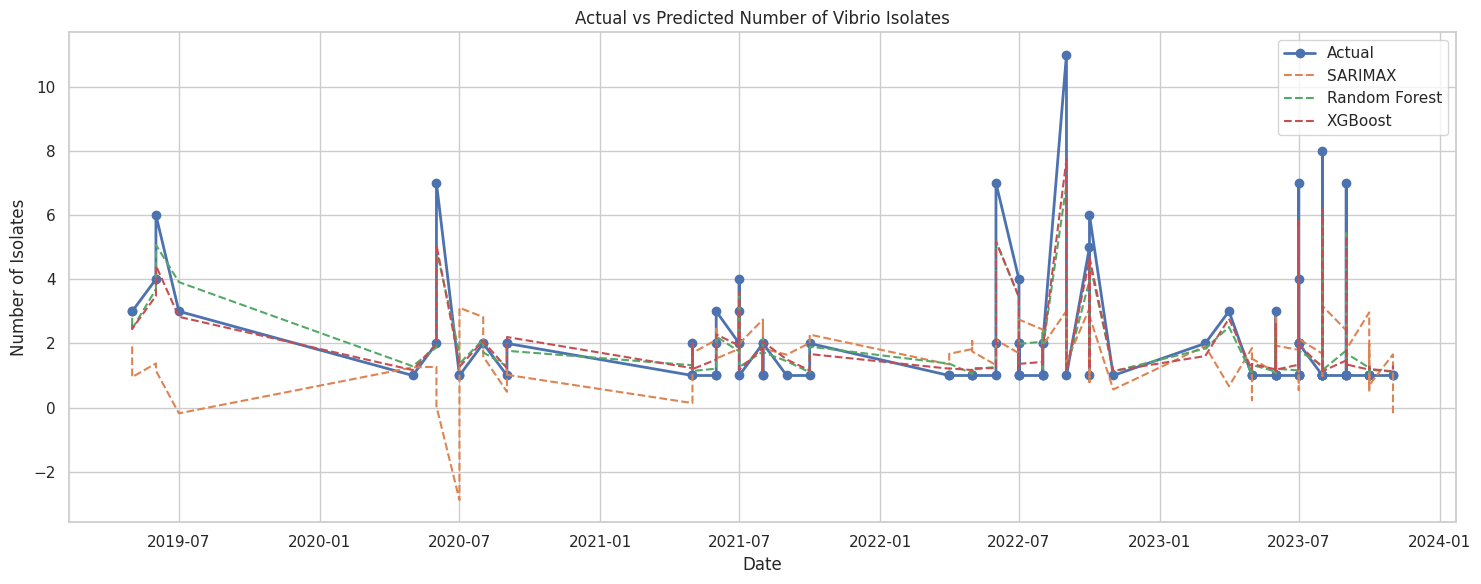

In [28]:
# VIsualize the Data

import matplotlib.pyplot as plt

# Refit Random Forest and XGBoost on the full dataset
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
rf_pred = rf_model.predict(X)

xgb_model = XGBRegressor(n_estimators=2000, learning_rate=0.001, objective='reg:squarederror', random_state=42)
xgb_model.fit(X, y)
xgb_pred = xgb_model.predict(X)

# SARIMAX prediction already done earlier as sarimax_pred

# Plot all models vs actual
plt.figure(figsize=(15, 6))
plt.plot(df_model['date'], y, label='Actual', marker='o', linewidth=2)
plt.plot(df_model['date'], sarimax_pred, label='SARIMAX', linestyle='--')
plt.plot(df_model['date'], rf_pred, label='Random Forest', linestyle='--')
plt.plot(df_model['date'], xgb_pred, label='XGBoost', linestyle='--')

plt.title('Actual vs Predicted Number of Vibrio Isolates')
plt.xlabel('Date')
plt.ylabel('Number of Isolates')
plt.legend()
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_

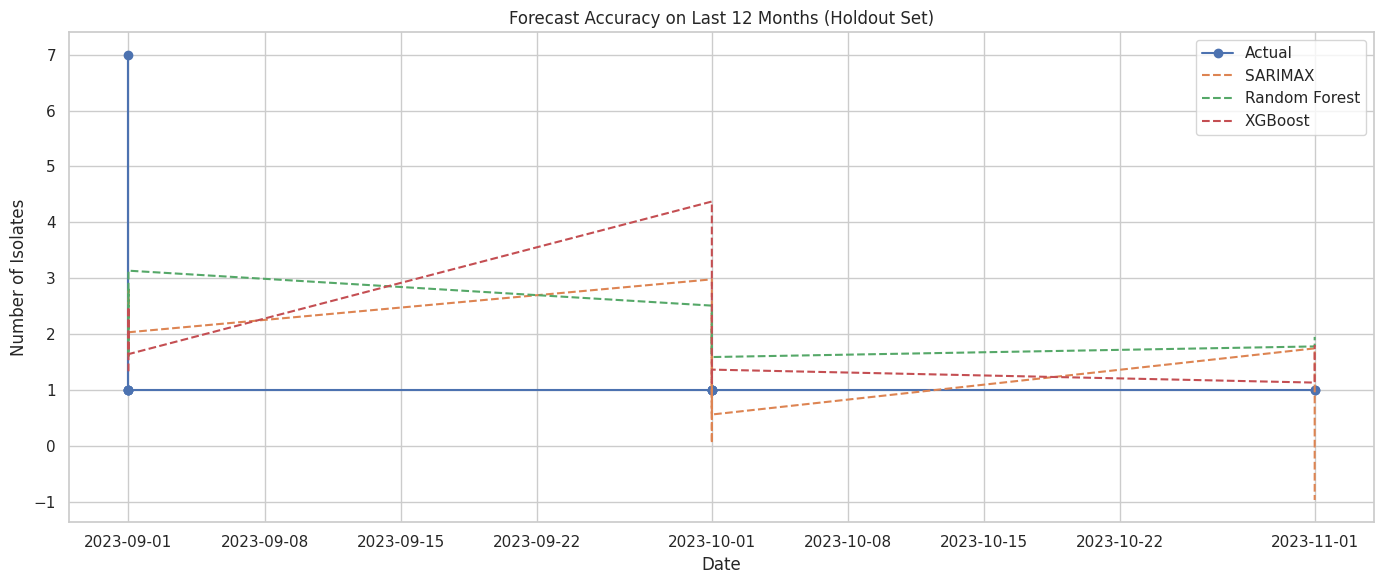

In [29]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg.csv"
df = pd.read_csv(url)

# Prepare the dataset
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df = df.sort_values("date")
df['sst_lag1'] = df['sst'].shift(1)
df['sss_lag1'] = df['sss'].shift(1)
df_model = df.dropna(subset=['sst_lag1', 'sss_lag1'])

# Define features and target
X = df_model[['sst', 'sss', 'sst_lag1', 'sss_lag1']]
y = df_model['Number_of_isolates']
dates = df_model['date']

# Split: use last 12 months as test set
train_size = -12
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
dates_test = dates.iloc[train_size:]

# Train and predict with Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Train and predict with XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Train and predict with SARIMAX
sarimax_model = SARIMAX(
    y_train, exog=X_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False)
sarimax_pred = sarimax_model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

# Plot actual vs predicted for the holdout period
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual', marker='o')
plt.plot(dates_test, sarimax_pred, label='SARIMAX', linestyle='--')
plt.plot(dates_test, rf_pred, label='Random Forest', linestyle='--')
plt.plot(dates_test, xgb_pred, label='XGBoost', linestyle='--')

plt.title("Forecast Accuracy on Last 12 Months (Holdout Set)")
plt.xlabel("Date")
plt.ylabel("Number of Isolates")
plt.legend()
plt.tight_layout()
plt.show()




**Model**

**SARIMAX:**	Captures time/seasonality structure	Can underperform with complex non-linear relationships and make unrealistic predictions (e.g. < 0)

**Random Forest:**	Stable and interpretable	Struggles with sharp peaks, can smooth too much

**XGBoost:**	Highly flexible, fits peaks well	Risk of overfitting; less interpretable

Holdout data is data not used for training

In [30]:
# 60 Month Forecast

# Merge forecasted SSS and SST
# Load the corrected forecast files
url_sss = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/random_forest_sss_forecast.csv"
url_sst = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/combined_sst_historical_forecast.csv"
sss_df = pd.read_csv(url_sss)
sst_df = pd.read_csv(url_sst)
print(sss_df.columns, sst_df.columns)

# Ensure proper datetime formatting
sst_df['date'] = pd.to_datetime(sst_df['date'])
sss_df['date'] = pd.to_datetime(sss_df['date'])

# Merge both forecasts on date
merged_forecast = pd.merge(sst_df[['date', 'SST']], sss_df[['date', 'sss_forecast']], on='date', how='inner')
merged_forecast.rename(columns={'SST': 'sst_forecast'}, inplace=True)

# Sort and add lag features
merged_forecast = merged_forecast.sort_values('date')
merged_forecast.reset_index(drop=True, inplace=True)
merged_forecast['sst_lag1'] = merged_forecast['sst_forecast'].shift(1)
merged_forecast['sss_lag1'] = merged_forecast['sss_forecast'].shift(1)

# Drop rows with missing lag values (only the first one)
#forecast_ready = merged_forecast.dropna().copy()

# Show the structure of the prepared forecast input
merged_forecast.head()

Index(['date', 'sss_forecast'], dtype='object') Index(['date', 'SST', 'type', 'Lower 95% CI', 'Upper 95% CI'], dtype='object')


,date,sst_forecast,sss_forecast,sst_lag1,sss_lag1
0,2018-08-01,20.810460,31.679759,NaN,NaN
1,2018-08-01,25.121695,31.679759,20.810460,31.679759
2,2019-05-01,25.239535,33.797745,25.121695,31.679759
3,2019-05-01,25.509852,33.797745,25.239535,33.797745
4,2019-06-01,28.886188,32.758971,25.509852,33.797745


Index(['date', 'sss_forecast'], dtype='object') Index(['date', 'SST', 'type', 'Lower 95% CI', 'Upper 95% CI'], dtype='object')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_

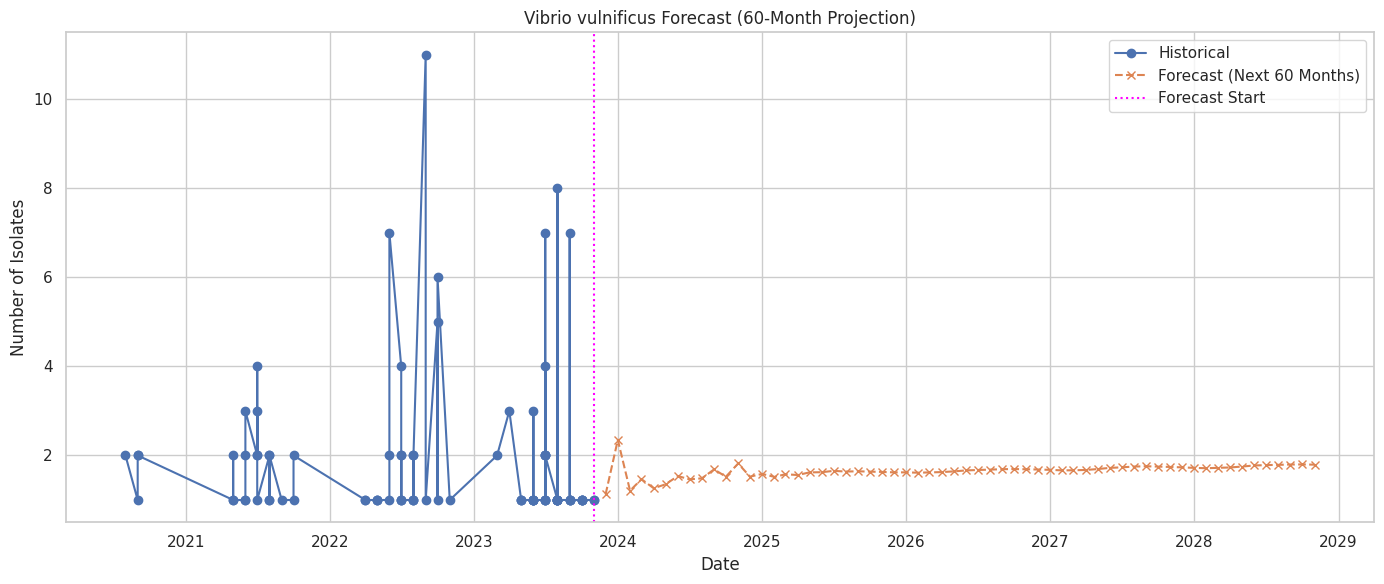

In [31]:

# STEP 1: Load and Prepare Projected SST/SSS


import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np

# Merge forecasted SSS and SST
# Load the corrected forecast files
url_sss = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/random_forest_sss_forecast.csv"
url_sst = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/combined_sst_historical_forecast.csv"
sss_df = pd.read_csv(url_sss)
sst_df = pd.read_csv(url_sst)
print(sss_df.columns, sst_df.columns)

# Ensure proper datetime formatting
sst_df['date'] = pd.to_datetime(sst_df['date'])
sss_df['date'] = pd.to_datetime(sss_df['date'])

# Merge both forecasts on date
merged_forecast = pd.merge(sst_df[['date', 'SST']], sss_df[['date', 'sss_forecast']], on='date', how='inner')
merged_forecast.rename(columns={'SST': 'sst_forecast'}, inplace=True)

# Sort and add lag features
merged_forecast = merged_forecast.sort_values('date')
merged_forecast.reset_index(drop=True, inplace=True)
merged_forecast['sst_lag1'] = merged_forecast['sst_forecast'].shift(1)
merged_forecast['sss_lag1'] = merged_forecast['sss_forecast'].shift(1)

# Drop missing lags
forecast_ready = merged_forecast.dropna().copy()


# STEP 2: Load and Prepare Historical Data


# Load historical Vibrio data with SST/SSS
url_hist = "https://raw.githubusercontent.com/AnkurBambhrolia/Vibrio/refs/heads/main/vv_sst_sss_sources_avg.csv"
df = pd.read_csv(url_hist)

# Convert to datetime
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df = df.sort_values('date')

# Create lag features
df['sst_lag1'] = df['sst'].rolling(window=12).mean().shift(1) # Ran 3 times: Lag 1, Rolling 12, and Lag 1 + Rolling 12
df['sss_lag1'] = df['sss'].rolling(window=12).mean().shift(1) # Ran 3 times: Lag 1, Rolling 12, and Lag 1 + Rolling 12

#rolling(window=12).mean()
# Drop NA
df_model = df.dropna(subset=['sst_lag1', 'sss_lag1'])

# Define training data
X_train = df_model[['sst', 'sss', 'sst_lag1', 'sss_lag1']]
y_train = df_model['Number_of_isolates']


# STEP 3: Train SARIMAX Model


sarimax_model = SARIMAX(
    y_train, exog=X_train,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# STEP 4: Forecast Future Cases


# Forecast only for future dates (after training data ends)
last_train_date = df_model['date'].max()
future_input = forecast_ready[forecast_ready['date'] > last_train_date].copy()

# Prepare future exog variables
X_future = future_input[['sst_forecast', 'sss_forecast', 'sst_lag1', 'sss_lag1']]
X_future.columns = ['sst', 'sss', 'sst_lag1', 'sss_lag1']

# Forecast
forecast = sarimax_model.predict(
    start=len(y_train),
    end=len(y_train) + len(X_future) - 1,
    exog=X_future
)
forecast = np.clip(forecast, 0, None)

# Fix index mismatch by assigning forecast by position
# Ensure DataFrame is same length as forecast
future_input = future_input.iloc[:len(forecast)].copy()
future_input['forecasted_isolates'] = forecast.values

# STEP 5: Plot the Results


plt.figure(figsize=(14, 6))
plt.plot(df_model['date'], y_train, label='Historical', marker='o')
plt.plot(future_input['date'], future_input['forecasted_isolates'], label='Forecast (Next 60 Months)', marker='x', linestyle='--')
plt.axvline(last_train_date, color='magenta', linestyle=':', label='Forecast Start')
plt.title("Vibrio vulnificus Forecast (60-Month Projection)")
plt.xlabel("Date")
plt.ylabel("Number of Isolates")
plt.legend()
plt.tight_layout()
plt.show()


# STEP 6: Export Forecast


# Save to CSV
future_input.columns
future_input[['date', 'forecasted_isolates','sss_forecast','sst_forecast','sst_lag1','sss_lag1']].to_csv("vv_forecast_60_months_final.csv", index=False)
from google.colab import files
#files.download("vv_forecast_60_months_final.csv")

In [32]:
#Model Validation for each modification in lag and rolling window

print("AIC:", sarimax_model.aic)
print("BIC:", sarimax_model.bic)

AIC: 319.0859903816579
BIC: 340.06259044423484
